In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

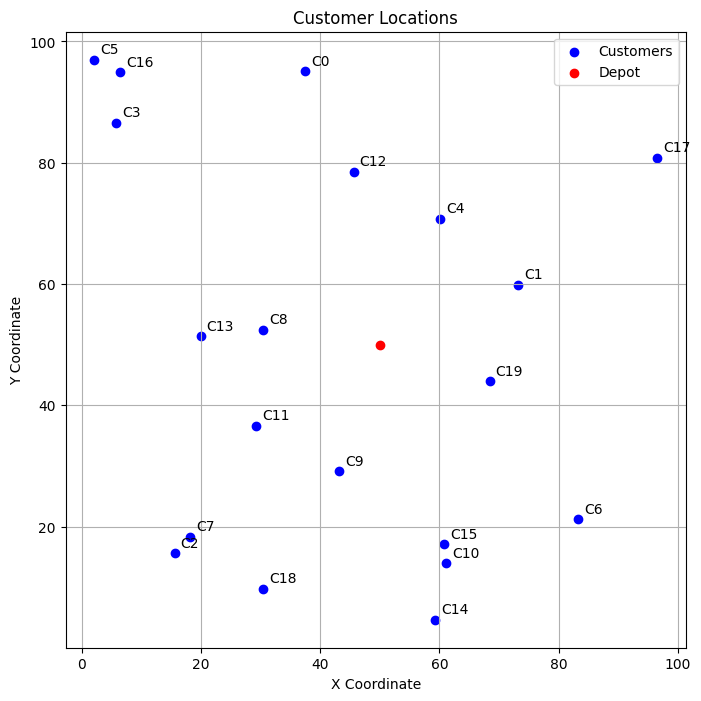

In [52]:
# Parameters
num_customers = 20  # Number of customers
num_vehicles = 5    # Number of vehicles
vehicle_capacity = 15
depot_location = np.array([50, 50])

# Generate random customer locations and demands
np.random.seed(42)
customer_locations = np.random.rand(num_customers, 2) * 100  # 100x100 grid
customer_demands = np.random.randint(1, 5, size=num_customers)  # Demands between 1 and 4

# Plot the customers and depot
plt.figure(figsize=(8,8))
plt.scatter(customer_locations[:,0], customer_locations[:,1], c='blue', label='Customers')
plt.scatter(depot_location[0], depot_location[1], c='red', label='Depot')
for i, loc in enumerate(customer_locations):
    plt.text(loc[0]+1, loc[1]+1, f'C{i}')
plt.legend()
plt.title('Customer Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()


In [53]:
# VRP Environment
class VRPEnvironment:
    def __init__(self, customer_locations, customer_demands, num_vehicles, vehicle_capacity, depot_location):
        self.customer_locations = customer_locations
        self.customer_demands = customer_demands
        self.num_customers = len(customer_locations)
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.depot_location = depot_location
        self.reset()

    def reset(self):
        self.remaining_customers = set(range(self.num_customers))
        self.vehicle_positions = [self.depot_location.copy() for _ in range(self.num_vehicles)]
        self.vehicle_loads = [0 for _ in range(self.num_vehicles)]  # Load carried
        self.vehicle_routes = [[self.depot_location.copy()] for _ in range(self.num_vehicles)]  # Route taken
        self.vehicle_route_indices = [[] for _ in range(self.num_vehicles)]  # To store customer indices
        self.vehicle_distances = [0 for _ in range(self.num_vehicles)]  # Initialize vehicle distances
        self.done = False
        self.steps = 0
        return self.get_state()

    def get_state(self):
        state = {
            'vehicle_positions': np.array(self.vehicle_positions),
            'vehicle_loads': np.array(self.vehicle_loads),
            'remaining_customers': self.remaining_customers.copy(),
            'customer_demands': self.customer_demands.copy(),
            'customer_locations': self.customer_locations.copy(),
        }
        return state

    def step(self, actions):
        rewards = np.zeros(self.num_vehicles)
        for i, action in enumerate(actions):
            if action == -1:
                # Return to depot
                prev_pos = self.vehicle_positions[i]
                distance = np.linalg.norm(self.depot_location - prev_pos)
                rewards[i] -= distance
                self.vehicle_positions[i] = self.depot_location.copy()
                self.vehicle_loads[i] = 0
                self.vehicle_routes[i].append(self.depot_location.copy())
                self.vehicle_distances[i] += distance  # Update vehicle distance
            elif action in self.remaining_customers:
                demand = self.customer_demands[action]
                if self.vehicle_loads[i] + demand <= self.vehicle_capacity:
                    # Move to customer
                    prev_pos = self.vehicle_positions[i]
                    new_pos = self.customer_locations[action]
                    distance = np.linalg.norm(new_pos - prev_pos)
                    rewards[i] -= distance
                    self.vehicle_positions[i] = new_pos.copy()
                    self.vehicle_loads[i] += demand
                    self.vehicle_routes[i].append(new_pos.copy())
                    self.vehicle_route_indices[i].append(action)  # Store customer index
                    self.remaining_customers.remove(action)
                    self.vehicle_distances[i] += distance  # Update vehicle distance
                else:
                    # Over capacity
                    rewards[i] -= 10  # Penalty
            else:
                # Invalid action
                rewards[i] -= 5  # Penalty

        self.steps += 1
        done = len(self.remaining_customers) == 0 or self.steps >= 100
        next_state = self.get_state()
        return next_state, rewards, done, {}

In [54]:
# DQN Agent
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [55]:
# State Vector Function
def get_state_vector(state):
    vehicle_positions = state['vehicle_positions'].flatten()
    vehicle_loads = state['vehicle_loads']
    remaining_customers_mask = np.array([1 if i in state['remaining_customers'] else 0 for i in range(num_customers)])
    customer_demands = state['customer_demands']
    customer_locations = state['customer_locations'].flatten()
    state_vector = np.concatenate([
        vehicle_positions,
        vehicle_loads,
        customer_locations,
        customer_demands,
        remaining_customers_mask
    ])
    return state_vector

In [56]:
# Drawing Function with Arrows
def draw_routes(vehicle_routes, title):
    plt.figure(figsize=(8,8))
    plt.scatter(customer_locations[:,0], customer_locations[:,1], c='blue', label='Customers')
    plt.scatter(depot_location[0], depot_location[1], c='red', label='Depot')
    for i, loc in enumerate(customer_locations):
        plt.text(loc[0]+1, loc[1]+1, f'C{i}')
    colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray']
    for i, route in enumerate(vehicle_routes):
        route = np.array(route)
        plt.plot(route[:,0], route[:,1], c=colors[i % len(colors)], label=f'Vehicle {i}')
        # Draw arrows
        for j in range(len(route)-1):
            start = route[j]
            end = route[j+1]
            plt.arrow(start[0], start[1], end[0]-start[0], end[1]-start[1],
                      head_width=1.5, length_includes_head=True, color=colors[i % len(colors)], alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

Episode 1/2000, Total Rewards: -989.0183692893107, Total Distance: 979.0183692893107


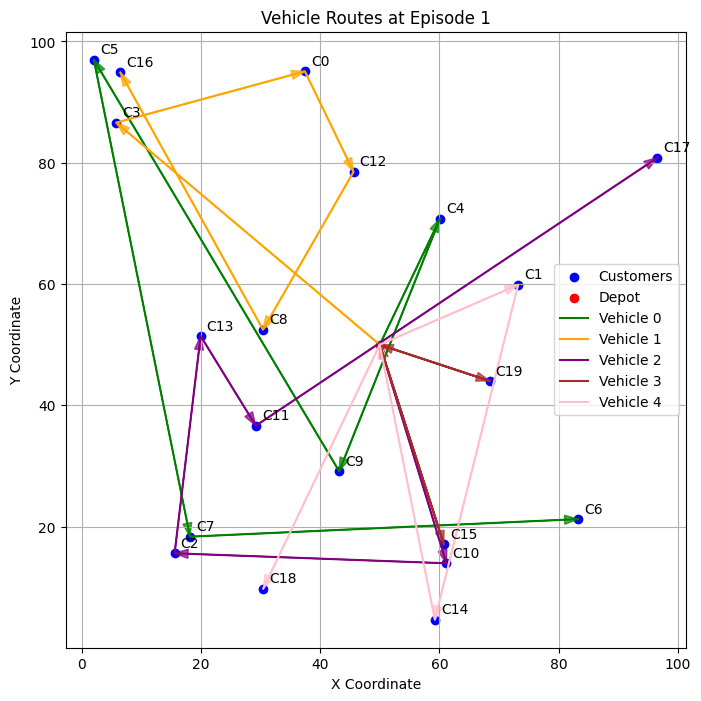

Episode 2/2000, Total Rewards: -1120.394518931315, Total Distance: 1070.394518931315
Episode 3/2000, Total Rewards: -1195.563605557549, Total Distance: 1165.563605557549
Episode 4/2000, Total Rewards: -1201.1116702450854, Total Distance: 1156.1116702450854
Episode 5/2000, Total Rewards: -1195.4507642991694, Total Distance: 1175.4507642991694
Episode 6/2000, Total Rewards: -1255.687391689058, Total Distance: 1225.687391689058
Episode 7/2000, Total Rewards: -1162.438032084446, Total Distance: 1122.438032084446
Episode 8/2000, Total Rewards: -1132.7136009784183, Total Distance: 1082.7136009784183
Episode 9/2000, Total Rewards: -1222.0718249320576, Total Distance: 1197.0718249320576
Episode 10/2000, Total Rewards: -1180.0535538228305, Total Distance: 1160.0535538228305
Episode 11/2000, Total Rewards: -1327.8482710464812, Total Distance: 1292.8482710464812
Episode 12/2000, Total Rewards: -1073.375636588423, Total Distance: 1063.375636588423
Episode 13/2000, Total Rewards: -920.685946606427,

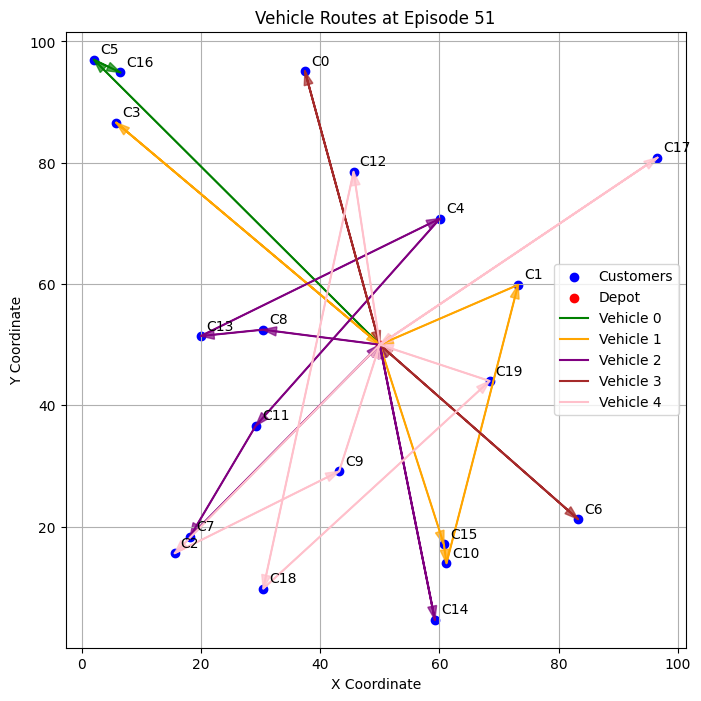

Episode 52/2000, Total Rewards: -1218.2965036212263, Total Distance: 1193.2965036212263
Episode 53/2000, Total Rewards: -1465.4603821864748, Total Distance: 1460.4603821864748
Episode 54/2000, Total Rewards: -1328.387473243251, Total Distance: 1193.3874732432512
Episode 55/2000, Total Rewards: -1382.346760186981, Total Distance: 1277.346760186981
Episode 56/2000, Total Rewards: -1267.88542603633, Total Distance: 1227.88542603633
Episode 57/2000, Total Rewards: -1244.496448667413, Total Distance: 1244.496448667413
Episode 58/2000, Total Rewards: -1209.2068674971244, Total Distance: 1194.2068674971244
Episode 59/2000, Total Rewards: -1303.7769660933034, Total Distance: 1118.7769660933034
Episode 60/2000, Total Rewards: -1257.2347069021234, Total Distance: 1252.2347069021234
Episode 61/2000, Total Rewards: -1374.8104624290888, Total Distance: 1234.8104624290888
Episode 62/2000, Total Rewards: -1276.1075704960106, Total Distance: 1271.1075704960106
Episode 63/2000, Total Rewards: -1115.772

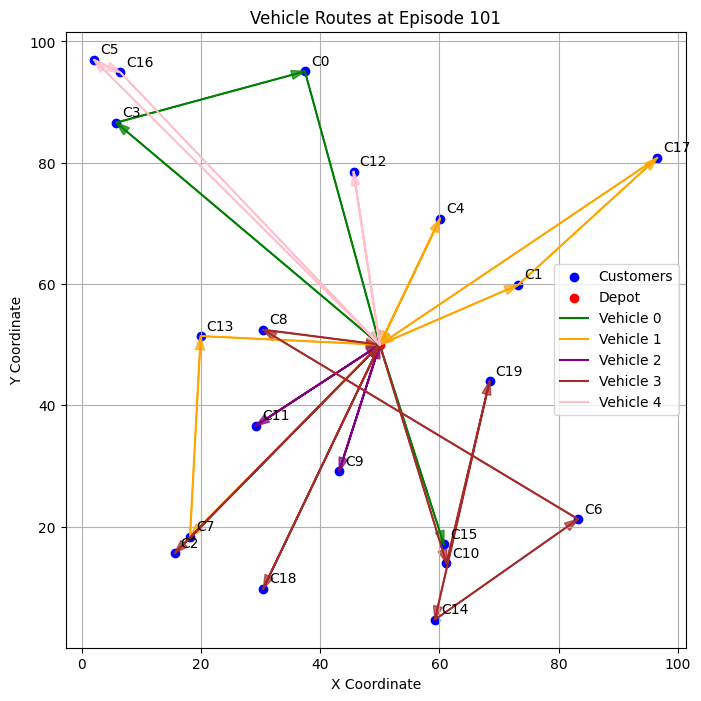

Episode 102/2000, Total Rewards: -1354.1943328725647, Total Distance: 1339.1943328725647
Episode 103/2000, Total Rewards: -1371.4198780989896, Total Distance: 1371.4198780989896
Episode 104/2000, Total Rewards: -1159.80284857599, Total Distance: 1159.80284857599
Episode 105/2000, Total Rewards: -1179.2504664432115, Total Distance: 1179.2504664432115
Episode 106/2000, Total Rewards: -1274.968645103965, Total Distance: 1274.968645103965
Episode 107/2000, Total Rewards: -1283.6005282519536, Total Distance: 1283.6005282519536
Episode 108/2000, Total Rewards: -1153.1421841703636, Total Distance: 1123.1421841703636
Episode 109/2000, Total Rewards: -1158.0537956341705, Total Distance: 1148.0537956341705
Episode 110/2000, Total Rewards: -1361.2252769726533, Total Distance: 1361.2252769726533
Episode 111/2000, Total Rewards: -1027.4409627901223, Total Distance: 1017.4409627901222
Episode 112/2000, Total Rewards: -1208.6291995320464, Total Distance: 1208.6291995320464
Episode 113/2000, Total Rew

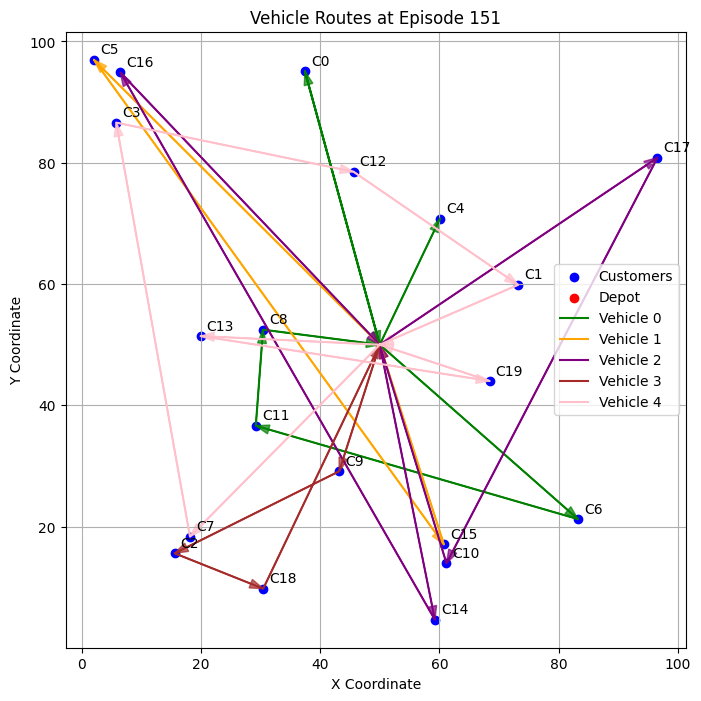

Episode 152/2000, Total Rewards: -1306.769602528913, Total Distance: 1301.769602528913
Episode 153/2000, Total Rewards: -1410.622689078268, Total Distance: 1405.622689078268
Episode 154/2000, Total Rewards: -1335.4029341323348, Total Distance: 1330.4029341323348
Episode 155/2000, Total Rewards: -1238.4673258766848, Total Distance: 1233.4673258766848
Episode 156/2000, Total Rewards: -957.2522323144447, Total Distance: 952.2522323144447
Episode 157/2000, Total Rewards: -1241.8073270982868, Total Distance: 1241.8073270982868
Episode 158/2000, Total Rewards: -1111.8878766598123, Total Distance: 1111.8878766598123
Episode 159/2000, Total Rewards: -1119.3586781344668, Total Distance: 1114.3586781344668
Episode 160/2000, Total Rewards: -1040.0869691655244, Total Distance: 1035.0869691655244
Episode 161/2000, Total Rewards: -1397.6290285135228, Total Distance: 1392.6290285135228
Episode 162/2000, Total Rewards: -1060.4240712880878, Total Distance: 1050.4240712880878
Episode 163/2000, Total Rew

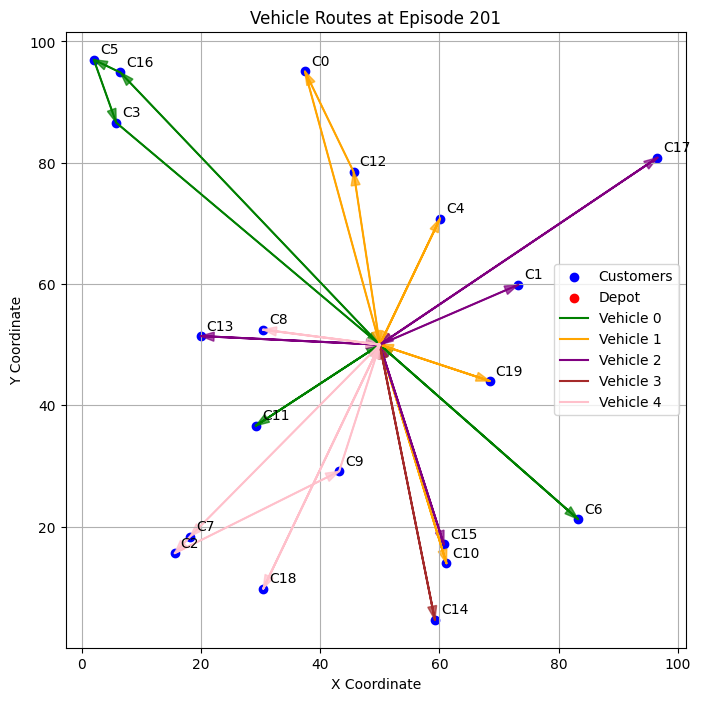

Episode 202/2000, Total Rewards: -1138.983329721709, Total Distance: 1133.983329721709
Episode 203/2000, Total Rewards: -1298.5494667053474, Total Distance: 1298.5494667053474
Episode 204/2000, Total Rewards: -1224.9819857926957, Total Distance: 1219.9819857926957
Episode 205/2000, Total Rewards: -1141.224157973467, Total Distance: 1141.224157973467
Episode 206/2000, Total Rewards: -1323.1343880181726, Total Distance: 1323.1343880181726
Episode 207/2000, Total Rewards: -1263.021333921195, Total Distance: 1263.021333921195
Episode 208/2000, Total Rewards: -1314.1198356758605, Total Distance: 1314.1198356758605
Episode 209/2000, Total Rewards: -1313.418303576071, Total Distance: 1313.418303576071
Episode 210/2000, Total Rewards: -984.2485800203332, Total Distance: 979.2485800203332
Episode 211/2000, Total Rewards: -1258.3257076297336, Total Distance: 1258.3257076297336
Episode 212/2000, Total Rewards: -1107.067961912014, Total Distance: 1102.067961912014
Episode 213/2000, Total Rewards: 

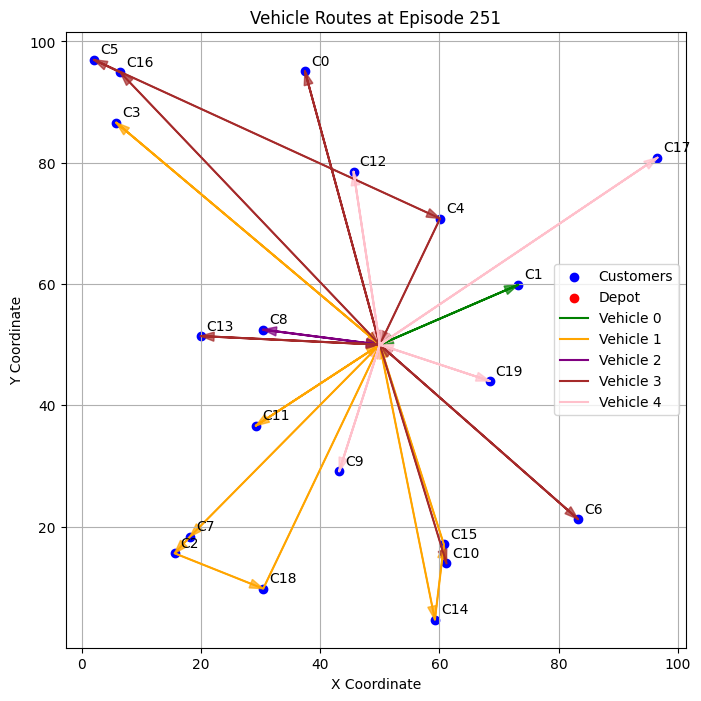

Episode 252/2000, Total Rewards: -1065.501239965112, Total Distance: 1065.501239965112
Episode 253/2000, Total Rewards: -1079.5893843020804, Total Distance: 1064.5893843020804
Episode 254/2000, Total Rewards: -1230.4634642953454, Total Distance: 1220.4634642953454
Episode 255/2000, Total Rewards: -1198.88801325318, Total Distance: 1198.88801325318
Episode 256/2000, Total Rewards: -1253.823010204965, Total Distance: 1238.823010204965
Episode 257/2000, Total Rewards: -870.5432829169838, Total Distance: 870.5432829169838
Episode 258/2000, Total Rewards: -965.7884875992522, Total Distance: 965.7884875992522
Episode 259/2000, Total Rewards: -1097.8178542358198, Total Distance: 1092.8178542358198
Episode 260/2000, Total Rewards: -1234.9865088209335, Total Distance: 1224.9865088209335
Episode 261/2000, Total Rewards: -1030.4523314814055, Total Distance: 1030.4523314814055
Episode 262/2000, Total Rewards: -1180.5441143161968, Total Distance: 1180.5441143161968
Episode 263/2000, Total Rewards: 

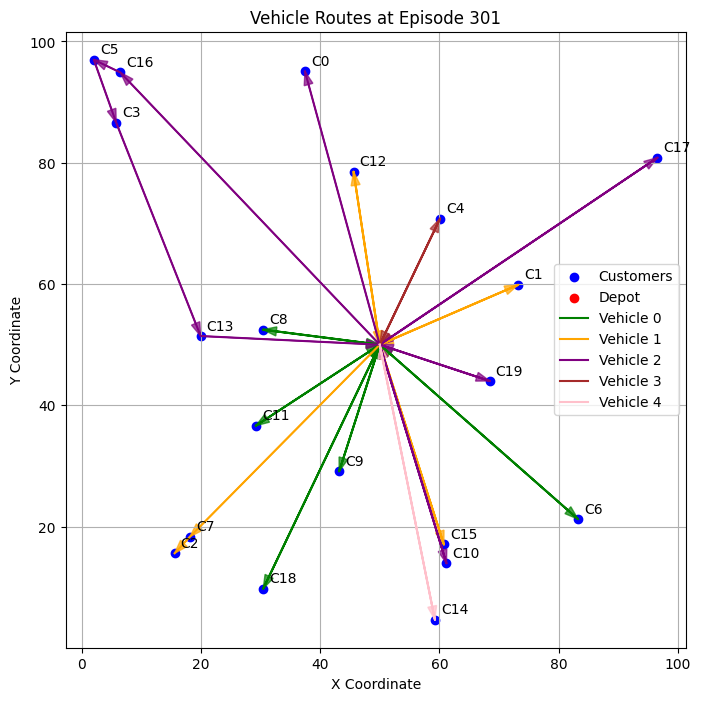

Episode 302/2000, Total Rewards: -1119.830326208843, Total Distance: 1114.830326208843
Episode 303/2000, Total Rewards: -1214.3898658403211, Total Distance: 1199.3898658403211
Episode 304/2000, Total Rewards: -1141.773883265807, Total Distance: 1141.773883265807
Episode 305/2000, Total Rewards: -1229.2648943313582, Total Distance: 1219.2648943313582
Episode 306/2000, Total Rewards: -1006.5510103360006, Total Distance: 1006.5510103360006
Episode 307/2000, Total Rewards: -1065.4612514227097, Total Distance: 1060.4612514227097
Episode 308/2000, Total Rewards: -959.7641469378956, Total Distance: 959.7641469378956
Episode 309/2000, Total Rewards: -1023.7980639780069, Total Distance: 1023.7980639780069
Episode 310/2000, Total Rewards: -1094.8491740487436, Total Distance: 1094.8491740487436
Episode 311/2000, Total Rewards: -1243.040302447663, Total Distance: 1233.040302447663
Episode 312/2000, Total Rewards: -1148.2017417773138, Total Distance: 1138.2017417773138
Episode 313/2000, Total Rewar

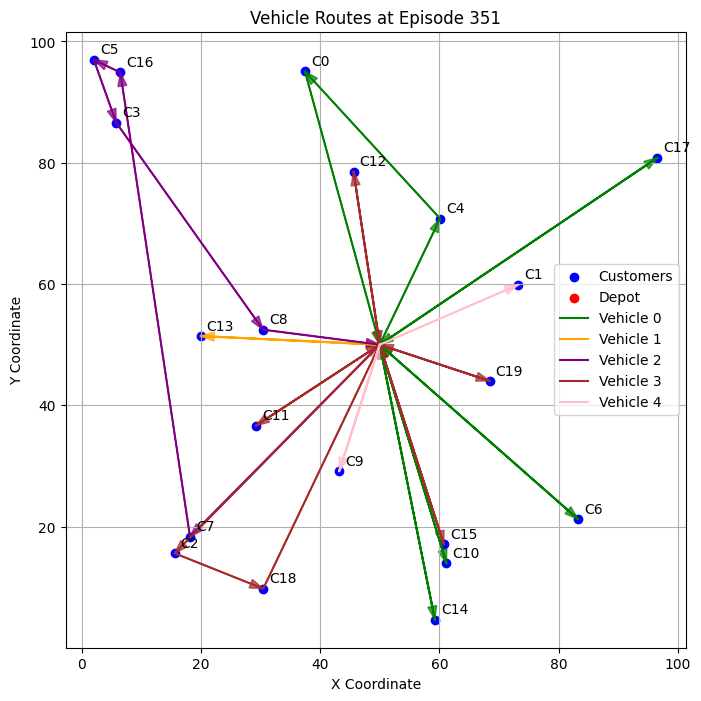

Episode 352/2000, Total Rewards: -1171.8119053306502, Total Distance: 1171.8119053306502
Episode 353/2000, Total Rewards: -1124.7175884904382, Total Distance: 1119.7175884904382
Episode 354/2000, Total Rewards: -987.4228572150137, Total Distance: 807.4228572150139
Episode 355/2000, Total Rewards: -1246.0859748462253, Total Distance: 1061.0859748462253
Episode 356/2000, Total Rewards: -1098.3244355675401, Total Distance: 1098.3244355675401
Episode 357/2000, Total Rewards: -980.1401151900799, Total Distance: 980.1401151900799
Episode 358/2000, Total Rewards: -1503.8071437188705, Total Distance: 973.8071437188703
Episode 359/2000, Total Rewards: -1091.6551642888141, Total Distance: 1091.6551642888141
Episode 360/2000, Total Rewards: -972.5527813917652, Total Distance: 972.5527813917652
Episode 361/2000, Total Rewards: -1065.1866186663258, Total Distance: 1060.1866186663258
Episode 362/2000, Total Rewards: -1132.0781189938812, Total Distance: 1132.0781189938812
Episode 363/2000, Total Rewa

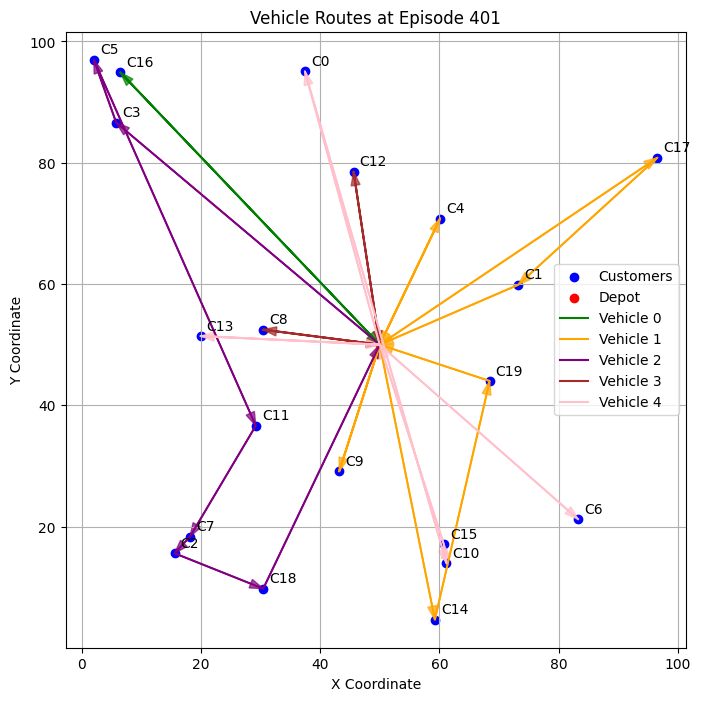

Episode 402/2000, Total Rewards: -1248.225498920908, Total Distance: 963.225498920908
Episode 403/2000, Total Rewards: -1093.3932775618846, Total Distance: 1093.3932775618846
Episode 404/2000, Total Rewards: -1198.270061327467, Total Distance: 1188.270061327467
Episode 405/2000, Total Rewards: -1139.4832820105744, Total Distance: 1139.4832820105744
Episode 406/2000, Total Rewards: -1187.5545272477364, Total Distance: 1177.5545272477364
Episode 407/2000, Total Rewards: -1150.5113875492402, Total Distance: 1145.5113875492402
Episode 408/2000, Total Rewards: -1145.9820170527025, Total Distance: 970.9820170527026
Episode 409/2000, Total Rewards: -1233.3491881291725, Total Distance: 1133.3491881291725
Episode 410/2000, Total Rewards: -1049.7128406284662, Total Distance: 959.7128406284662
Episode 411/2000, Total Rewards: -1042.0314676831417, Total Distance: 1027.0314676831417
Episode 412/2000, Total Rewards: -1085.1834493639537, Total Distance: 1080.1834493639537
Episode 413/2000, Total Rewa

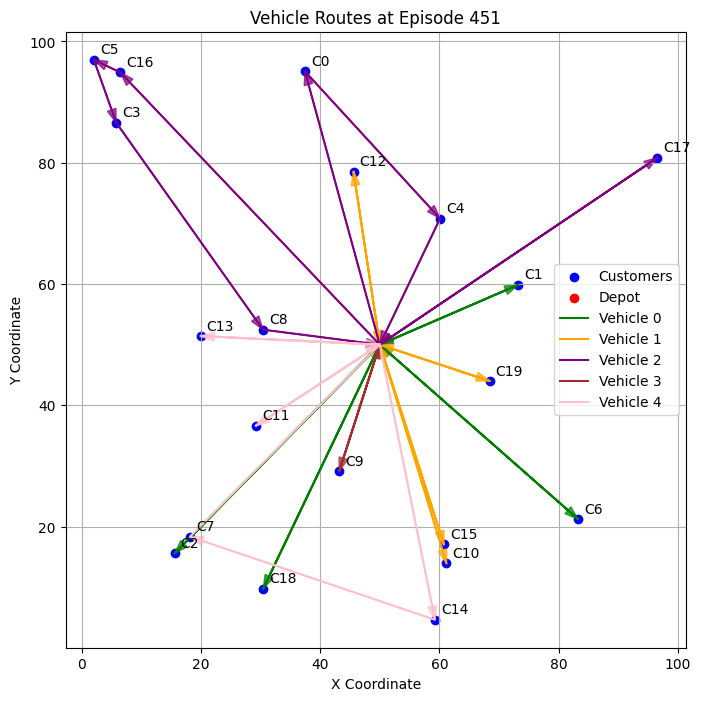

Episode 452/2000, Total Rewards: -1083.2023052753157, Total Distance: 943.2023052753157
Episode 453/2000, Total Rewards: -870.0568246932813, Total Distance: 870.0568246932813
Episode 454/2000, Total Rewards: -1125.1997271762116, Total Distance: 1125.1997271762116
Episode 455/2000, Total Rewards: -1063.4478098311881, Total Distance: 913.4478098311881
Episode 456/2000, Total Rewards: -1114.5827966581712, Total Distance: 1044.5827966581712
Episode 457/2000, Total Rewards: -1092.8649901182935, Total Distance: 1092.8649901182935
Episode 458/2000, Total Rewards: -1087.823308000688, Total Distance: 1082.823308000688
Episode 459/2000, Total Rewards: -1188.0487542037265, Total Distance: 1008.0487542037265
Episode 460/2000, Total Rewards: -1133.7828021981964, Total Distance: 1128.7828021981964
Episode 461/2000, Total Rewards: -1082.7376459531183, Total Distance: 1077.7376459531183
Episode 462/2000, Total Rewards: -1172.0227535787765, Total Distance: 1002.0227535787765
Episode 463/2000, Total Rew

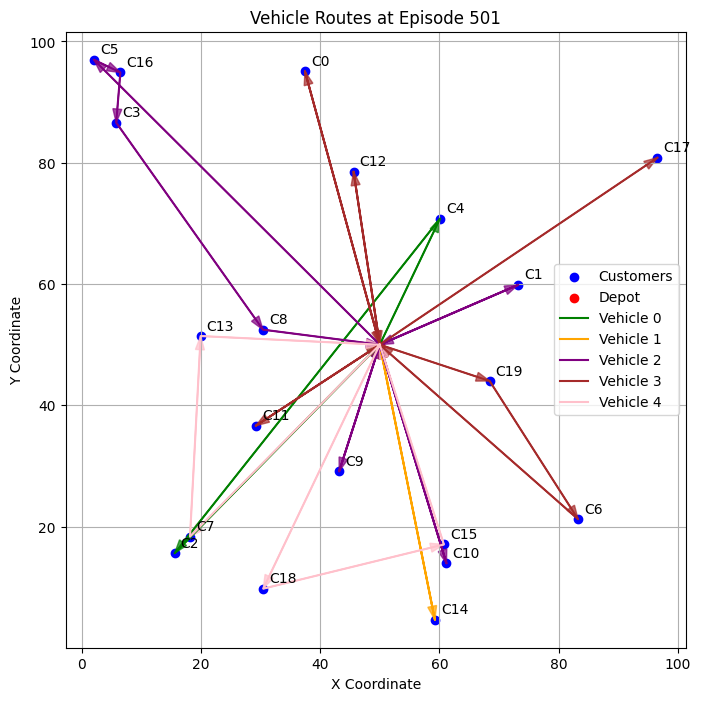

Episode 502/2000, Total Rewards: -1061.349087314954, Total Distance: 1061.349087314954
Episode 503/2000, Total Rewards: -1003.923900377623, Total Distance: 993.923900377623
Episode 504/2000, Total Rewards: -1118.7466986904708, Total Distance: 1048.746698690471
Episode 505/2000, Total Rewards: -921.3834507215447, Total Distance: 886.3834507215447
Episode 506/2000, Total Rewards: -1193.2628436539528, Total Distance: 1183.2628436539528
Episode 507/2000, Total Rewards: -991.2926348939376, Total Distance: 986.2926348939376
Episode 508/2000, Total Rewards: -1161.9516529963744, Total Distance: 1141.9516529963742
Episode 509/2000, Total Rewards: -1090.5701267332734, Total Distance: 1075.5701267332734
Episode 510/2000, Total Rewards: -1126.2778729378415, Total Distance: 1126.2778729378415
Episode 511/2000, Total Rewards: -974.0121016528021, Total Distance: 969.0121016528021
Episode 512/2000, Total Rewards: -1108.7769335614023, Total Distance: 1108.7769335614023
Episode 513/2000, Total Rewards: 

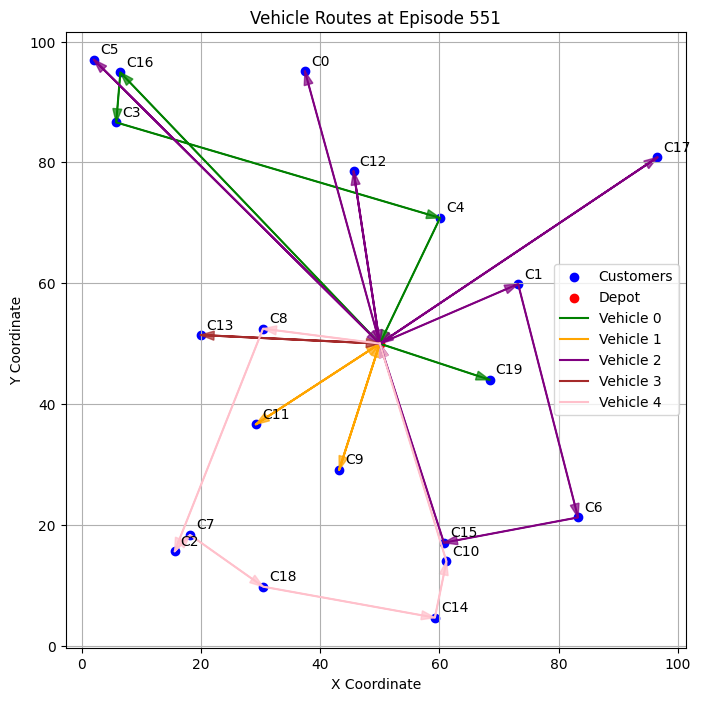

Episode 552/2000, Total Rewards: -1217.9550466693133, Total Distance: 1207.9550466693133
Episode 553/2000, Total Rewards: -1403.5816118040361, Total Distance: 1013.5816118040361
Episode 554/2000, Total Rewards: -1188.5419283173837, Total Distance: 1183.5419283173837
Episode 555/2000, Total Rewards: -1033.3877171317686, Total Distance: 1028.3877171317686
Episode 556/2000, Total Rewards: -1167.1215367100785, Total Distance: 1117.1215367100788
Episode 557/2000, Total Rewards: -1107.9729140428253, Total Distance: 1002.9729140428253
Episode 558/2000, Total Rewards: -1252.3639925143195, Total Distance: 1242.3639925143195
Episode 559/2000, Total Rewards: -1058.6147101126319, Total Distance: 1053.6147101126319
Episode 560/2000, Total Rewards: -882.9656508684582, Total Distance: 862.9656508684582
Episode 561/2000, Total Rewards: -1781.6072605205247, Total Distance: 1036.6072605205247
Episode 562/2000, Total Rewards: -1050.139737141934, Total Distance: 1050.139737141934
Episode 563/2000, Total R

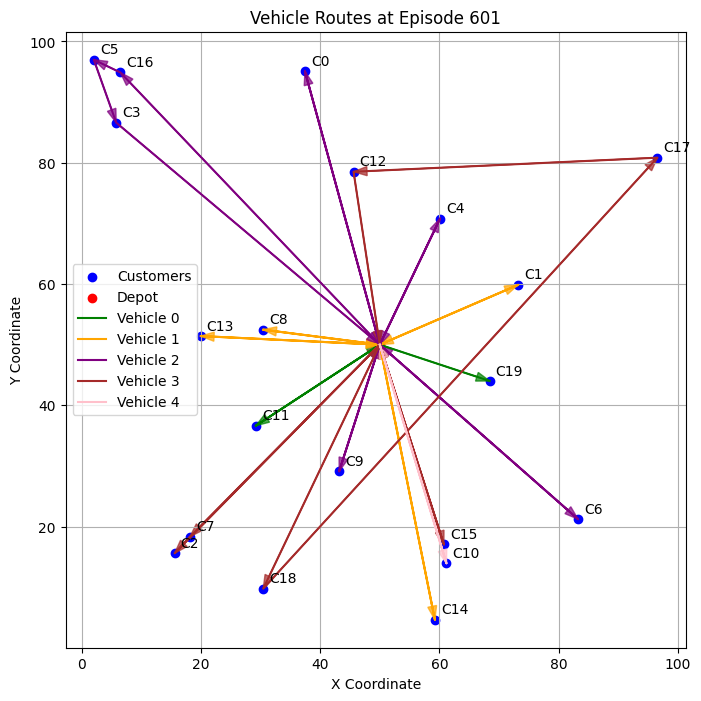

Episode 602/2000, Total Rewards: -891.1035409158096, Total Distance: 891.1035409158096
Episode 603/2000, Total Rewards: -1038.3674368852453, Total Distance: 1038.3674368852453
Episode 604/2000, Total Rewards: -1214.239779244224, Total Distance: 1194.239779244224
Episode 605/2000, Total Rewards: -1045.8734290475309, Total Distance: 1040.8734290475309
Episode 606/2000, Total Rewards: -1100.4496186822262, Total Distance: 1090.4496186822262
Episode 607/2000, Total Rewards: -1050.9360091359922, Total Distance: 1040.9360091359922
Episode 608/2000, Total Rewards: -1053.6355358980331, Total Distance: 1043.6355358980331
Episode 609/2000, Total Rewards: -959.8930048127136, Total Distance: 944.8930048127136
Episode 610/2000, Total Rewards: -936.5187565104394, Total Distance: 911.5187565104394
Episode 611/2000, Total Rewards: -1310.4165732522454, Total Distance: 1205.4165732522454
Episode 612/2000, Total Rewards: -1247.971363205599, Total Distance: 1242.971363205599
Episode 613/2000, Total Rewards

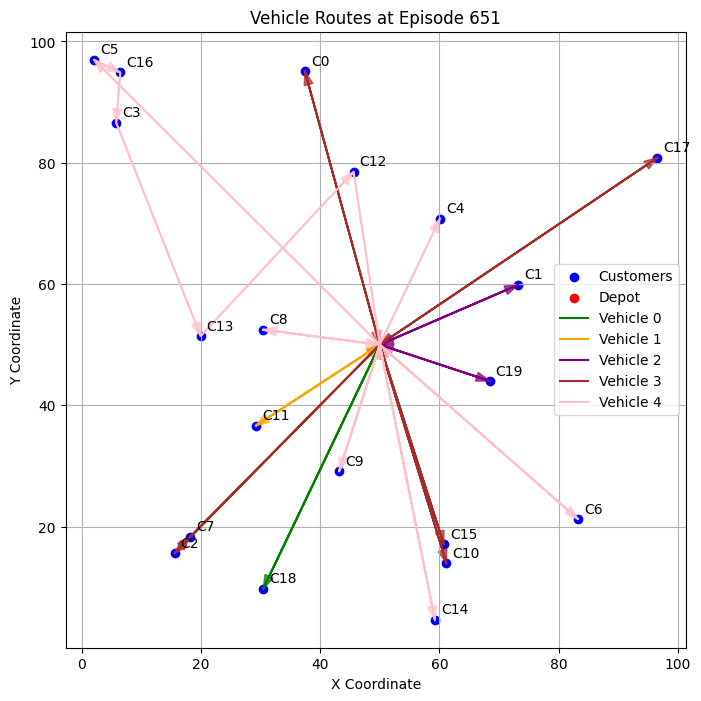

Episode 652/2000, Total Rewards: -1005.8478333162606, Total Distance: 985.8478333162606
Episode 653/2000, Total Rewards: -1229.8901497038783, Total Distance: 1179.8901497038783
Episode 654/2000, Total Rewards: -1041.5020696136874, Total Distance: 961.5020696136874
Episode 655/2000, Total Rewards: -1162.070770181192, Total Distance: 1157.0707701811923
Episode 656/2000, Total Rewards: -1038.009487971356, Total Distance: 1018.0094879713561
Episode 657/2000, Total Rewards: -1058.340906663832, Total Distance: 1058.340906663832
Episode 658/2000, Total Rewards: -1105.973603237638, Total Distance: 1100.973603237638
Episode 659/2000, Total Rewards: -1269.5911278067642, Total Distance: 1264.5911278067642
Episode 660/2000, Total Rewards: -1255.5210801819985, Total Distance: 1255.5210801819985
Episode 661/2000, Total Rewards: -1120.3920491186395, Total Distance: 1065.3920491186395
Episode 662/2000, Total Rewards: -1027.7276019956794, Total Distance: 1027.7276019956794
Episode 663/2000, Total Rewar

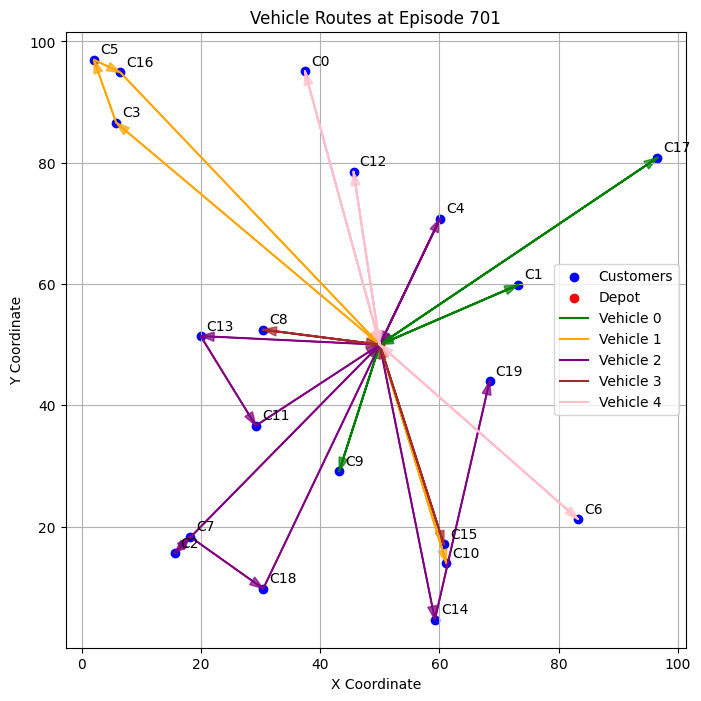

Episode 702/2000, Total Rewards: -1034.5179740697113, Total Distance: 1034.5179740697113
Episode 703/2000, Total Rewards: -1207.132613974828, Total Distance: 962.1326139748279
Episode 704/2000, Total Rewards: -913.1253012806833, Total Distance: 913.1253012806833
Episode 705/2000, Total Rewards: -1011.9519383168135, Total Distance: 1001.9519383168135
Episode 706/2000, Total Rewards: -1241.1015848152786, Total Distance: 951.1015848152787
Episode 707/2000, Total Rewards: -1236.2694988195894, Total Distance: 961.2694988195897
Episode 708/2000, Total Rewards: -1181.4832253676436, Total Distance: 1181.4832253676436
Episode 709/2000, Total Rewards: -1242.3115449617553, Total Distance: 1242.3115449617553
Episode 710/2000, Total Rewards: -1068.5628542712548, Total Distance: 1063.5628542712548
Episode 711/2000, Total Rewards: -1293.688362086135, Total Distance: 1293.688362086135
Episode 712/2000, Total Rewards: -1103.647361128656, Total Distance: 1103.647361128656
Episode 713/2000, Total Rewards

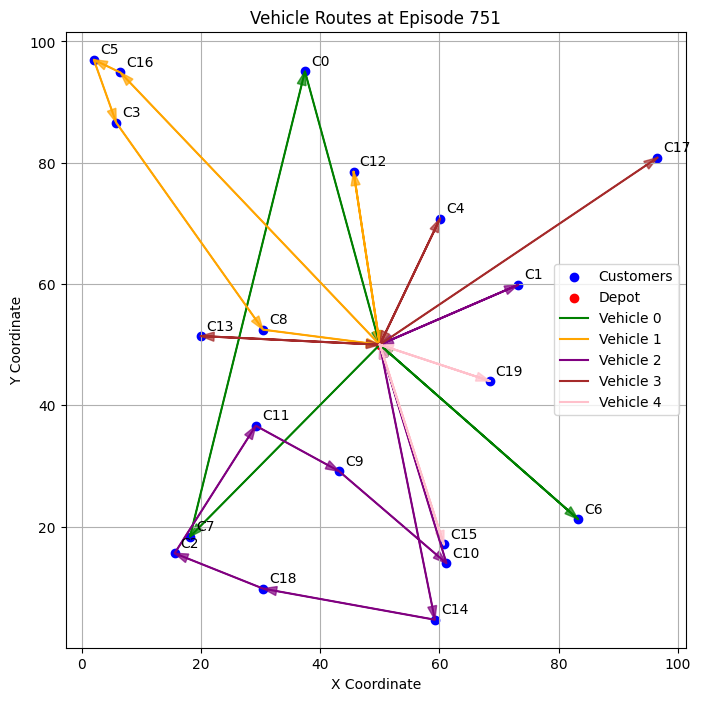

Episode 752/2000, Total Rewards: -1116.4675987493313, Total Distance: 876.467598749331
Episode 753/2000, Total Rewards: -1193.6570940556126, Total Distance: 1188.6570940556126
Episode 754/2000, Total Rewards: -994.0173836323065, Total Distance: 984.0173836323065
Episode 755/2000, Total Rewards: -1128.6201535179332, Total Distance: 1123.6201535179332
Episode 756/2000, Total Rewards: -1059.8669401714146, Total Distance: 1059.8669401714146
Episode 757/2000, Total Rewards: -1174.8818244589772, Total Distance: 1004.8818244589771
Episode 758/2000, Total Rewards: -1003.2030334863566, Total Distance: 983.2030334863566
Episode 759/2000, Total Rewards: -861.5156998348373, Total Distance: 861.5156998348373
Episode 760/2000, Total Rewards: -1146.6735956333366, Total Distance: 1136.6735956333366
Episode 761/2000, Total Rewards: -1240.5935316500538, Total Distance: 1235.5935316500538
Episode 762/2000, Total Rewards: -1153.9833746033487, Total Distance: 1153.9833746033487
Episode 763/2000, Total Rewa

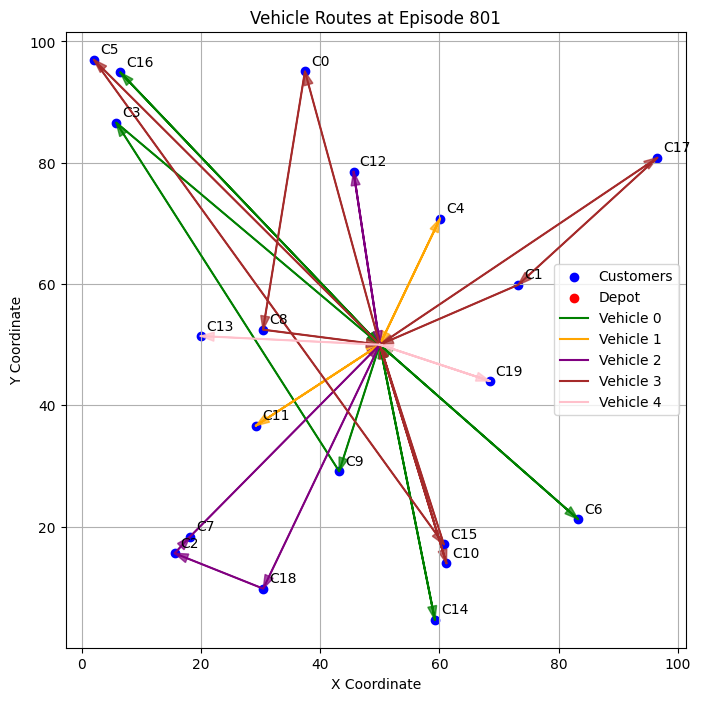

Episode 802/2000, Total Rewards: -1047.5020627959639, Total Distance: 1047.5020627959639
Episode 803/2000, Total Rewards: -1140.9857425794771, Total Distance: 1140.9857425794771
Episode 804/2000, Total Rewards: -1435.763054698395, Total Distance: 1175.7630546983953
Episode 805/2000, Total Rewards: -1169.9002391167705, Total Distance: 1169.9002391167705
Episode 806/2000, Total Rewards: -1317.0343963719974, Total Distance: 1117.0343963719974
Episode 807/2000, Total Rewards: -1197.8149138809113, Total Distance: 1192.8149138809113
Episode 808/2000, Total Rewards: -1168.739339043917, Total Distance: 1168.739339043917
Episode 809/2000, Total Rewards: -1048.9239840886285, Total Distance: 1038.9239840886285
Episode 810/2000, Total Rewards: -1243.1890728689486, Total Distance: 1083.1890728689486
Episode 811/2000, Total Rewards: -991.5915052921237, Total Distance: 986.5915052921237
Episode 812/2000, Total Rewards: -982.1244016330638, Total Distance: 977.1244016330638
Episode 813/2000, Total Rewa

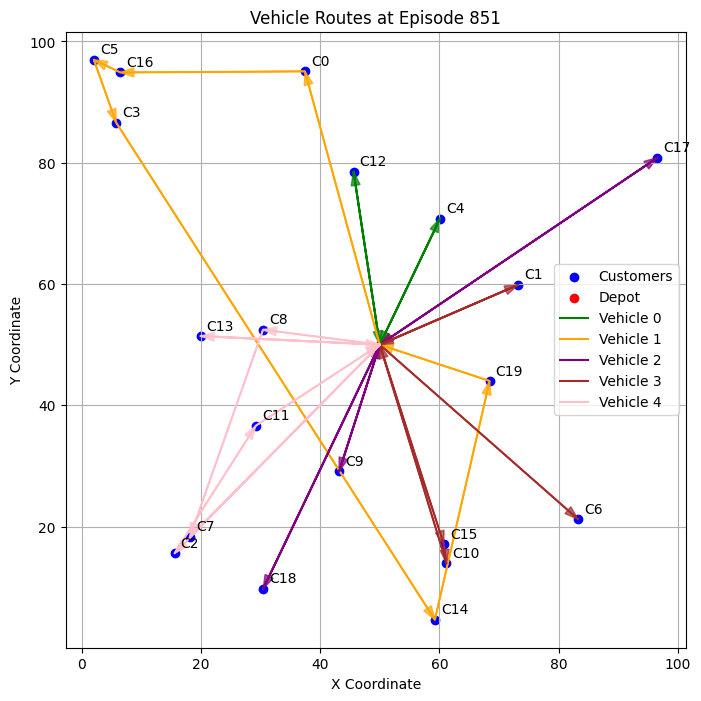

Episode 852/2000, Total Rewards: -1218.3360102375677, Total Distance: 1218.3360102375677
Episode 853/2000, Total Rewards: -1021.6291625835026, Total Distance: 1016.6291625835026
Episode 854/2000, Total Rewards: -891.69920499461, Total Distance: 891.69920499461
Episode 855/2000, Total Rewards: -998.0124432530681, Total Distance: 998.0124432530681
Episode 856/2000, Total Rewards: -1069.0847285586735, Total Distance: 1069.0847285586735
Episode 857/2000, Total Rewards: -1106.328660546035, Total Distance: 1106.328660546035
Episode 858/2000, Total Rewards: -1035.7790177420227, Total Distance: 1025.7790177420227
Episode 859/2000, Total Rewards: -1294.326140466906, Total Distance: 1294.326140466906
Episode 860/2000, Total Rewards: -1082.058173683932, Total Distance: 1082.058173683932
Episode 861/2000, Total Rewards: -949.3517848292432, Total Distance: 939.3517848292432
Episode 862/2000, Total Rewards: -1426.6425096719706, Total Distance: 1231.6425096719706
Episode 863/2000, Total Rewards: -116

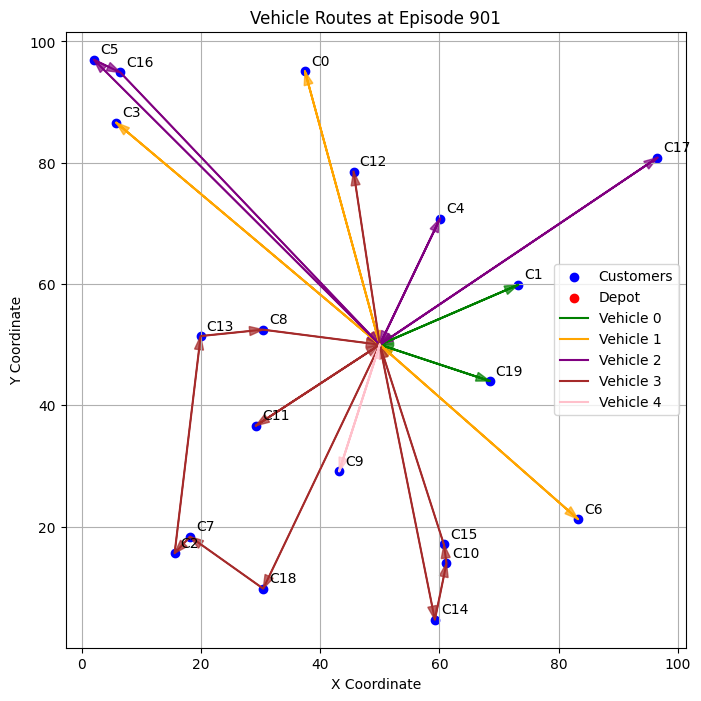

Episode 902/2000, Total Rewards: -1047.5445200149204, Total Distance: 1047.5445200149204
Episode 903/2000, Total Rewards: -1216.5361544552218, Total Distance: 1216.5361544552218
Episode 904/2000, Total Rewards: -1130.6928394563643, Total Distance: 1125.6928394563643
Episode 905/2000, Total Rewards: -1096.3219996174553, Total Distance: 1086.3219996174553
Episode 906/2000, Total Rewards: -1131.3127143719703, Total Distance: 1131.3127143719703
Episode 907/2000, Total Rewards: -1003.1685670984889, Total Distance: 1003.1685670984889
Episode 908/2000, Total Rewards: -1033.0605787408952, Total Distance: 1018.0605787408952
Episode 909/2000, Total Rewards: -1090.8254994100569, Total Distance: 1085.8254994100569
Episode 910/2000, Total Rewards: -1248.1386942843146, Total Distance: 1248.1386942843146
Episode 911/2000, Total Rewards: -1265.1738269269338, Total Distance: 1260.1738269269338
Episode 912/2000, Total Rewards: -1147.2471041700608, Total Distance: 1147.2471041700608
Episode 913/2000, Tot

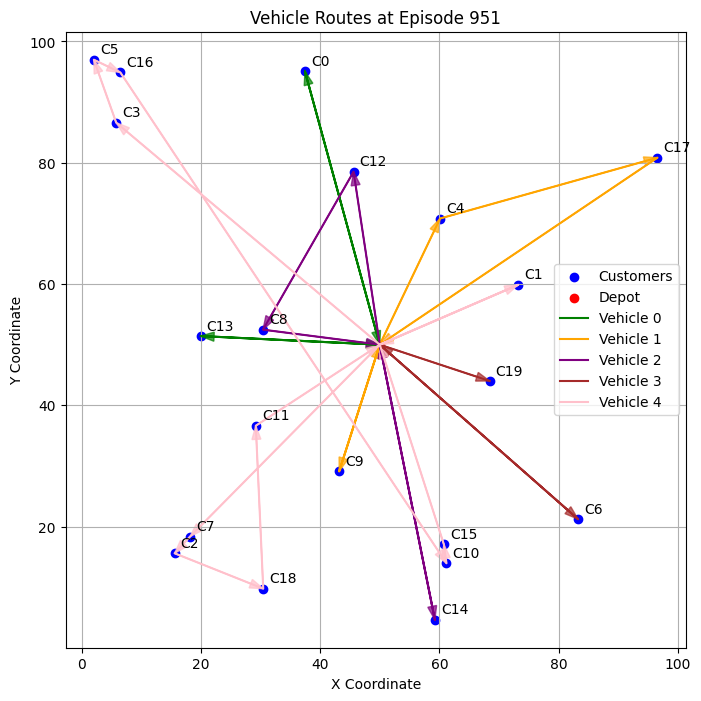

Episode 952/2000, Total Rewards: -1026.820968215192, Total Distance: 1021.820968215192
Episode 953/2000, Total Rewards: -1056.1140452354537, Total Distance: 1041.1140452354537
Episode 954/2000, Total Rewards: -1275.8757712141173, Total Distance: 1275.8757712141173
Episode 955/2000, Total Rewards: -934.9044957957483, Total Distance: 934.9044957957483
Episode 956/2000, Total Rewards: -1198.3214436307326, Total Distance: 1198.3214436307326
Episode 957/2000, Total Rewards: -1279.476927632742, Total Distance: 974.4769276327422
Episode 958/2000, Total Rewards: -983.2096310673851, Total Distance: 978.2096310673851
Episode 959/2000, Total Rewards: -878.3659030661534, Total Distance: 858.3659030661534
Episode 960/2000, Total Rewards: -1231.6806202795015, Total Distance: 1121.6806202795015
Episode 961/2000, Total Rewards: -968.9589379322083, Total Distance: 958.9589379322083
Episode 962/2000, Total Rewards: -1023.1390403039481, Total Distance: 1023.1390403039481
Episode 963/2000, Total Rewards: 

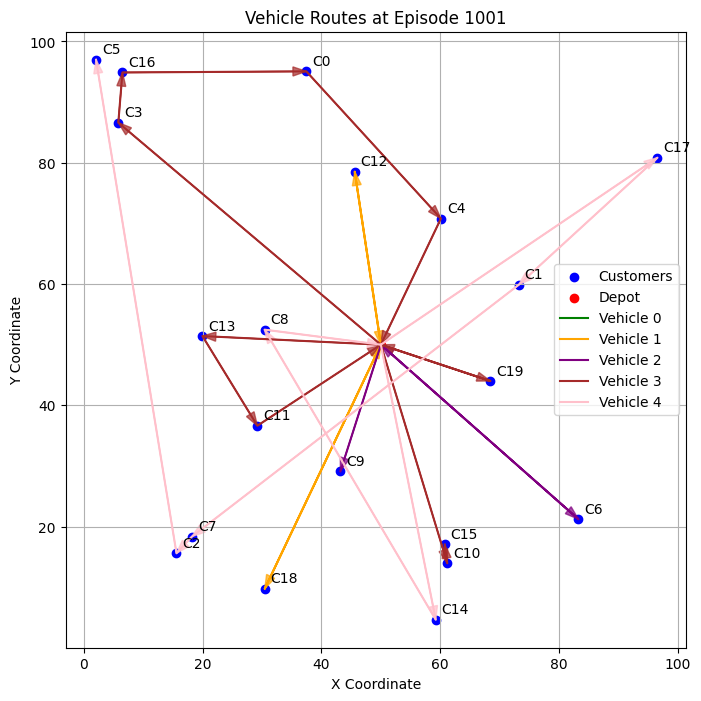

Episode 1002/2000, Total Rewards: -1017.6969297056785, Total Distance: 1002.6969297056785
Episode 1003/2000, Total Rewards: -994.9255333177382, Total Distance: 959.9255333177381
Episode 1004/2000, Total Rewards: -1060.406947185745, Total Distance: 1060.406947185745
Episode 1005/2000, Total Rewards: -966.3198817237192, Total Distance: 966.3198817237192
Episode 1006/2000, Total Rewards: -1052.1388046179247, Total Distance: 1052.1388046179247
Episode 1007/2000, Total Rewards: -1248.8404315792945, Total Distance: 1243.8404315792945
Episode 1008/2000, Total Rewards: -1055.4634484689473, Total Distance: 1040.4634484689473
Episode 1009/2000, Total Rewards: -1217.6467495839659, Total Distance: 1217.6467495839659
Episode 1010/2000, Total Rewards: -1036.576144867318, Total Distance: 1026.576144867318
Episode 1011/2000, Total Rewards: -1174.273002406872, Total Distance: 929.2730024068718
Episode 1012/2000, Total Rewards: -1204.4217186816095, Total Distance: 1024.4217186816095
Episode 1013/2000, T

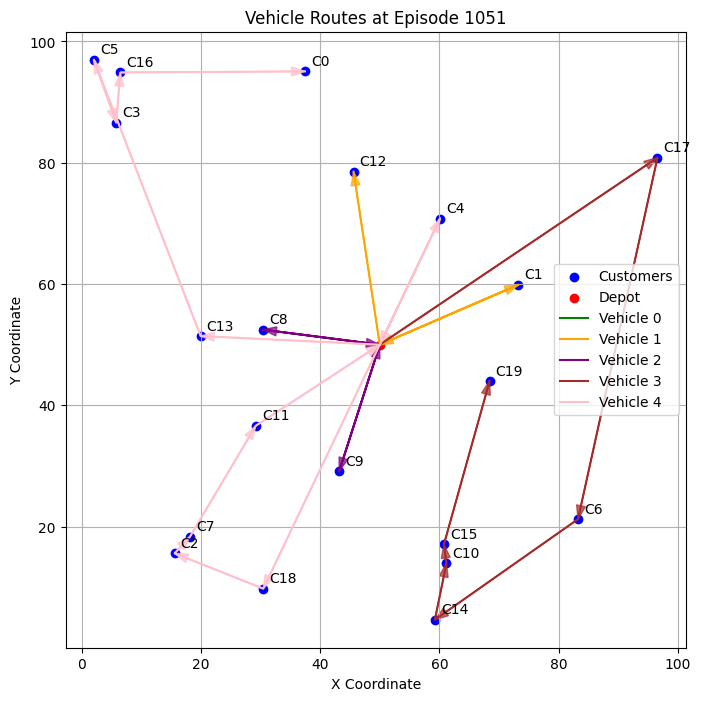

Episode 1052/2000, Total Rewards: -999.2046799435583, Total Distance: 879.2046799435582
Episode 1053/2000, Total Rewards: -1550.9528550163104, Total Distance: 880.9528550163104
Episode 1054/2000, Total Rewards: -1114.7007875734757, Total Distance: 1099.7007875734757
Episode 1055/2000, Total Rewards: -1577.4852866128085, Total Distance: 832.4852866128085
Episode 1056/2000, Total Rewards: -1207.778306121289, Total Distance: 1077.778306121289
Episode 1057/2000, Total Rewards: -1203.8892857294668, Total Distance: 923.8892857294667
Episode 1058/2000, Total Rewards: -1031.1240068435634, Total Distance: 991.1240068435633
Episode 1059/2000, Total Rewards: -1011.0094197695634, Total Distance: 946.0094197695634
Episode 1060/2000, Total Rewards: -1110.0808964118762, Total Distance: 895.0808964118761
Episode 1061/2000, Total Rewards: -1478.3573718187904, Total Distance: 1043.3573718187904
Episode 1062/2000, Total Rewards: -1335.0750862610016, Total Distance: 1025.0750862610014
Episode 1063/2000, T

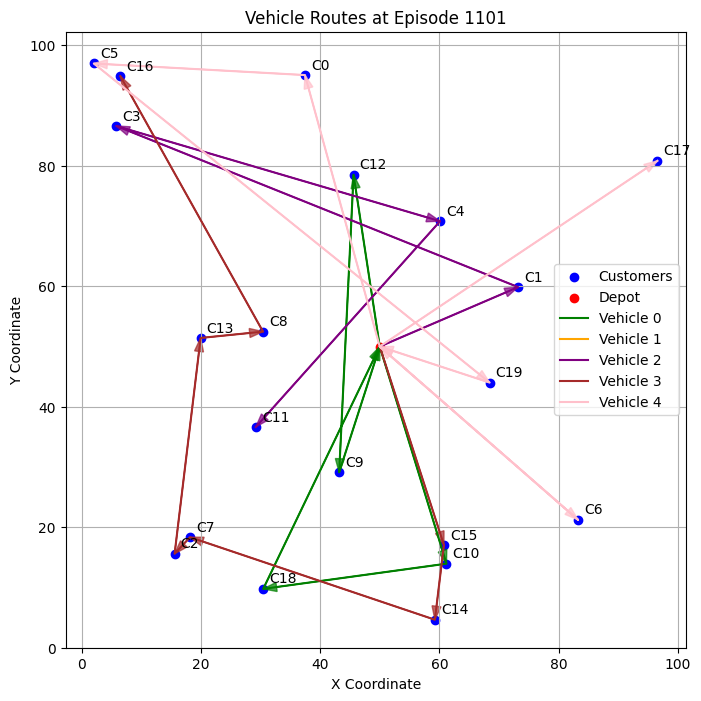

Episode 1102/2000, Total Rewards: -1357.0939083546875, Total Distance: 1087.0939083546875
Episode 1103/2000, Total Rewards: -1151.0505912662381, Total Distance: 1021.0505912662383
Episode 1104/2000, Total Rewards: -1127.075973749544, Total Distance: 952.0759737495438
Episode 1105/2000, Total Rewards: -774.5237448315787, Total Distance: 714.5237448315787
Episode 1106/2000, Total Rewards: -1173.9997700152137, Total Distance: 1013.9997700152137
Episode 1107/2000, Total Rewards: -1919.177419172015, Total Distance: 1114.177419172015
Episode 1108/2000, Total Rewards: -981.7507364643371, Total Distance: 901.7507364643371
Episode 1109/2000, Total Rewards: -1167.2095187155023, Total Distance: 932.2095187155023
Episode 1110/2000, Total Rewards: -1073.4237300473078, Total Distance: 818.4237300473077
Episode 1111/2000, Total Rewards: -1129.6192073516008, Total Distance: 1029.6192073516008
Episode 1112/2000, Total Rewards: -1139.8551728233037, Total Distance: 844.8551728233039
Episode 1113/2000, To

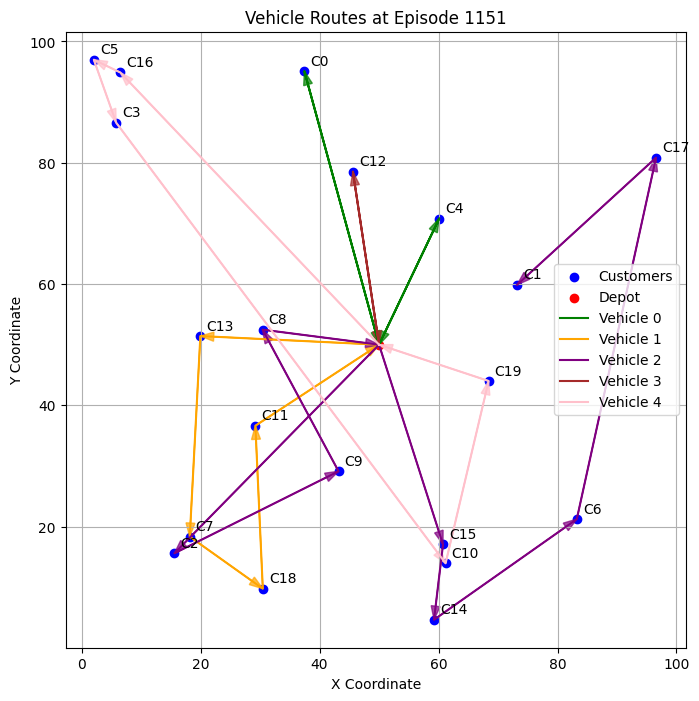

Episode 1152/2000, Total Rewards: -1102.953978155605, Total Distance: 952.953978155605
Episode 1153/2000, Total Rewards: -1271.7065774486325, Total Distance: 966.7065774486325
Episode 1154/2000, Total Rewards: -1157.1199499969352, Total Distance: 1027.1199499969352
Episode 1155/2000, Total Rewards: -1305.5944834094225, Total Distance: 980.5944834094225
Episode 1156/2000, Total Rewards: -1050.9270617297336, Total Distance: 935.9270617297336
Episode 1157/2000, Total Rewards: -931.380936695999, Total Distance: 891.380936695999
Episode 1158/2000, Total Rewards: -1110.5961843115635, Total Distance: 980.5961843115635
Episode 1159/2000, Total Rewards: -1138.4003155259106, Total Distance: 1003.4003155259107
Episode 1160/2000, Total Rewards: -1188.8992433741728, Total Distance: 988.8992433741729
Episode 1161/2000, Total Rewards: -1420.828330173943, Total Distance: 1110.828330173943
Episode 1162/2000, Total Rewards: -1085.794141826128, Total Distance: 865.794141826128
Episode 1163/2000, Total Re

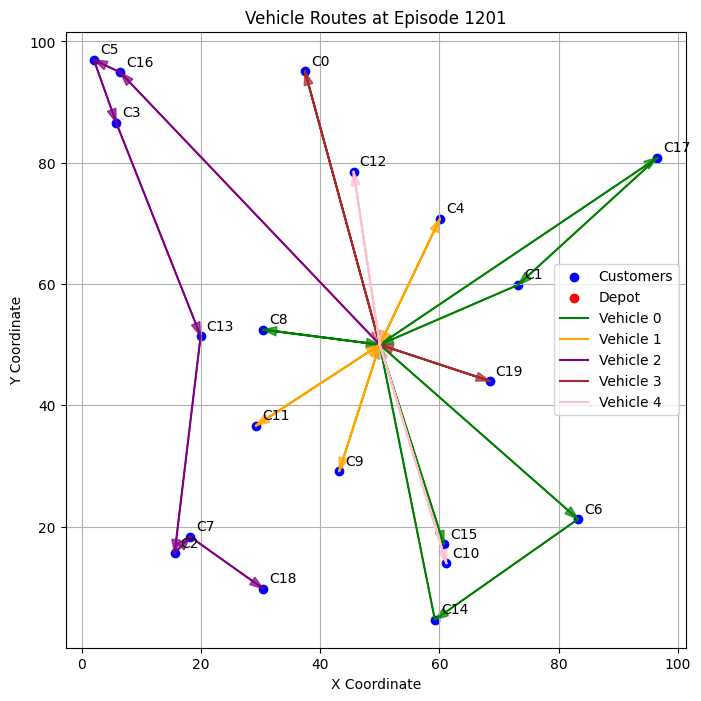

Episode 1202/2000, Total Rewards: -1167.3634125139338, Total Distance: 1007.3634125139339
Episode 1203/2000, Total Rewards: -1164.044249420309, Total Distance: 964.0442494203089
Episode 1204/2000, Total Rewards: -1060.735977117466, Total Distance: 935.7359771174662
Episode 1205/2000, Total Rewards: -1174.1483710777993, Total Distance: 1174.1483710777993
Episode 1206/2000, Total Rewards: -1430.0995600202723, Total Distance: 1055.0995600202723
Episode 1207/2000, Total Rewards: -1094.4287161367051, Total Distance: 1074.4287161367051
Episode 1208/2000, Total Rewards: -1304.0425539465355, Total Distance: 989.0425539465355
Episode 1209/2000, Total Rewards: -975.0927538064518, Total Distance: 840.0927538064518
Episode 1210/2000, Total Rewards: -1063.5532770207883, Total Distance: 978.5532770207883
Episode 1211/2000, Total Rewards: -1206.6353687776584, Total Distance: 1086.6353687776584
Episode 1212/2000, Total Rewards: -960.4896739462777, Total Distance: 945.4896739462777
Episode 1213/2000, T

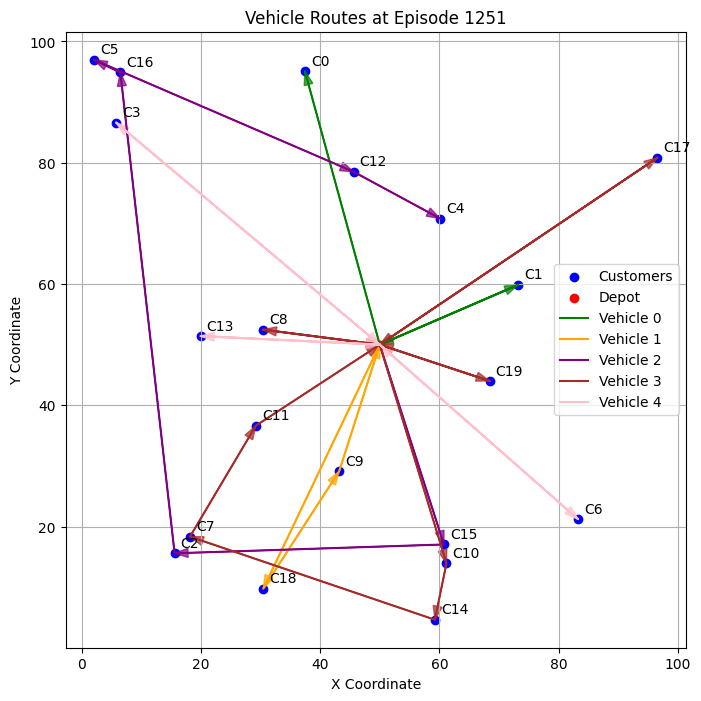

Episode 1252/2000, Total Rewards: -999.1650127511447, Total Distance: 994.1650127511447
Episode 1253/2000, Total Rewards: -893.2358977254373, Total Distance: 858.2358977254373
Episode 1254/2000, Total Rewards: -1296.2244876112527, Total Distance: 991.2244876112526
Episode 1255/2000, Total Rewards: -1339.4075185853378, Total Distance: 1029.4075185853378
Episode 1256/2000, Total Rewards: -1159.90750748729, Total Distance: 1019.9075074872901
Episode 1257/2000, Total Rewards: -1244.591448042894, Total Distance: 1034.591448042894
Episode 1258/2000, Total Rewards: -956.4818649816198, Total Distance: 941.4818649816198
Episode 1259/2000, Total Rewards: -1184.1373256192217, Total Distance: 964.1373256192217
Episode 1260/2000, Total Rewards: -1498.4420729781184, Total Distance: 1163.4420729781184
Episode 1261/2000, Total Rewards: -1418.557696725773, Total Distance: 1013.557696725773
Episode 1262/2000, Total Rewards: -1591.424623503591, Total Distance: 1331.424623503591
Episode 1263/2000, Total R

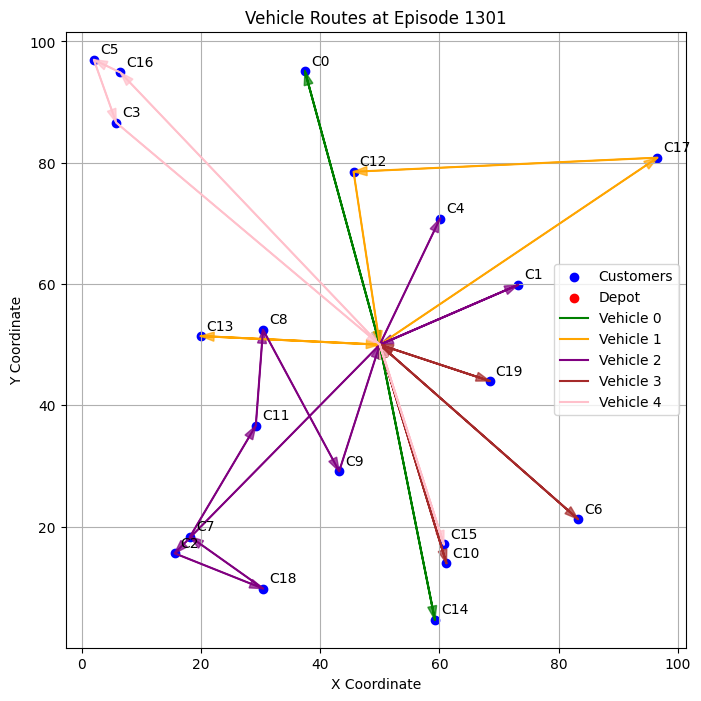

Episode 1302/2000, Total Rewards: -924.3775934445321, Total Distance: 754.3775934445321
Episode 1303/2000, Total Rewards: -1296.4762424862397, Total Distance: 1056.4762424862397
Episode 1304/2000, Total Rewards: -1133.276038676183, Total Distance: 1128.276038676183
Episode 1305/2000, Total Rewards: -1450.5977802700831, Total Distance: 1150.5977802700831
Episode 1306/2000, Total Rewards: -1193.9687583571208, Total Distance: 1183.9687583571208
Episode 1307/2000, Total Rewards: -1350.6342615549715, Total Distance: 1040.6342615549718
Episode 1308/2000, Total Rewards: -1061.249858580834, Total Distance: 966.2498585808338
Episode 1309/2000, Total Rewards: -977.2983242179985, Total Distance: 897.2983242179985
Episode 1310/2000, Total Rewards: -1097.1964823492644, Total Distance: 847.1964823492644
Episode 1311/2000, Total Rewards: -1523.3372654425534, Total Distance: 953.3372654425534
Episode 1312/2000, Total Rewards: -1072.9300977995254, Total Distance: 967.9300977995254
Episode 1313/2000, To

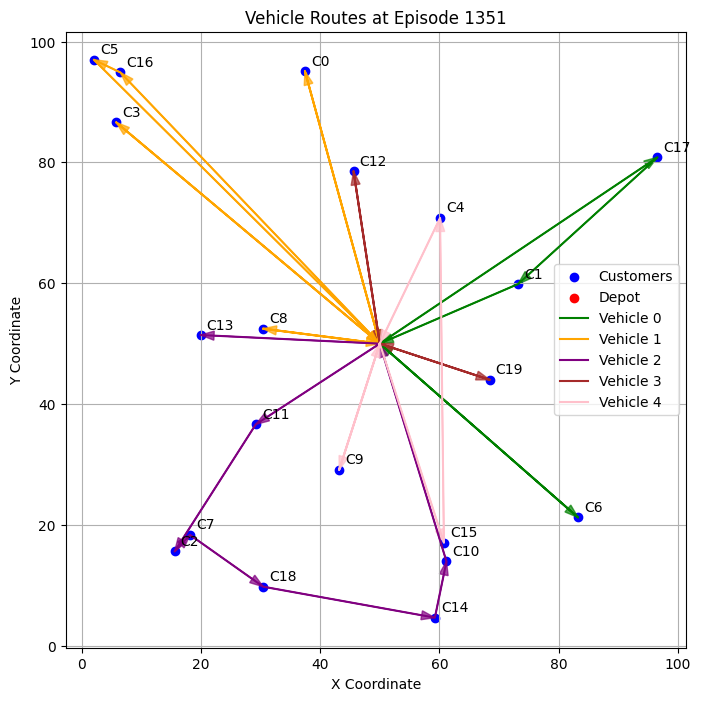

Episode 1352/2000, Total Rewards: -1068.298794904434, Total Distance: 813.2987949044343
Episode 1353/2000, Total Rewards: -1168.0288904024978, Total Distance: 1153.0288904024978
Episode 1354/2000, Total Rewards: -1138.6168708525472, Total Distance: 988.6168708525472
Episode 1355/2000, Total Rewards: -1059.0371595519337, Total Distance: 1049.0371595519337
Episode 1356/2000, Total Rewards: -1078.2863695887177, Total Distance: 973.2863695887177
Episode 1357/2000, Total Rewards: -914.5958293749793, Total Distance: 904.5958293749793
Episode 1358/2000, Total Rewards: -944.5824933266011, Total Distance: 869.5824933266011
Episode 1359/2000, Total Rewards: -995.8131947789923, Total Distance: 935.8131947789923
Episode 1360/2000, Total Rewards: -1099.0678941439105, Total Distance: 1079.0678941439105
Episode 1361/2000, Total Rewards: -970.2205794356914, Total Distance: 970.2205794356914
Episode 1362/2000, Total Rewards: -1602.1007579477673, Total Distance: 927.1007579477673
Episode 1363/2000, Tota

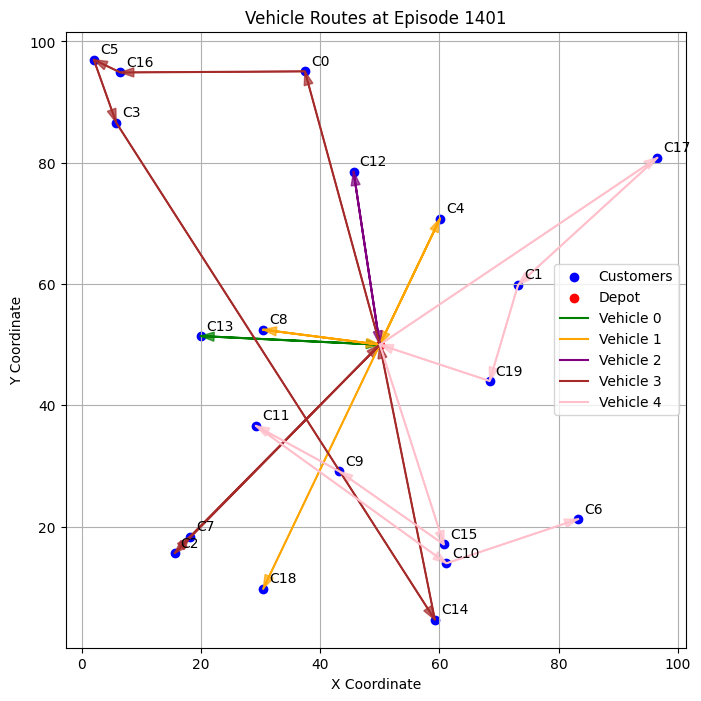

Episode 1402/2000, Total Rewards: -1053.7691091974561, Total Distance: 978.7691091974561
Episode 1403/2000, Total Rewards: -1164.741852641811, Total Distance: 909.741852641811
Episode 1404/2000, Total Rewards: -1098.4492491748733, Total Distance: 968.4492491748734
Episode 1405/2000, Total Rewards: -1180.9622968267581, Total Distance: 775.9622968267581
Episode 1406/2000, Total Rewards: -1265.6856900511586, Total Distance: 1120.6856900511586
Episode 1407/2000, Total Rewards: -1032.8738077537628, Total Distance: 1027.8738077537628
Episode 1408/2000, Total Rewards: -903.1968035389745, Total Distance: 883.1968035389745
Episode 1409/2000, Total Rewards: -1322.574353937404, Total Distance: 867.5743539374041
Episode 1410/2000, Total Rewards: -847.9517272280038, Total Distance: 817.9517272280038
Episode 1411/2000, Total Rewards: -1132.311627015696, Total Distance: 857.3116270156961
Episode 1412/2000, Total Rewards: -963.1118594087825, Total Distance: 848.1118594087825
Episode 1413/2000, Total R

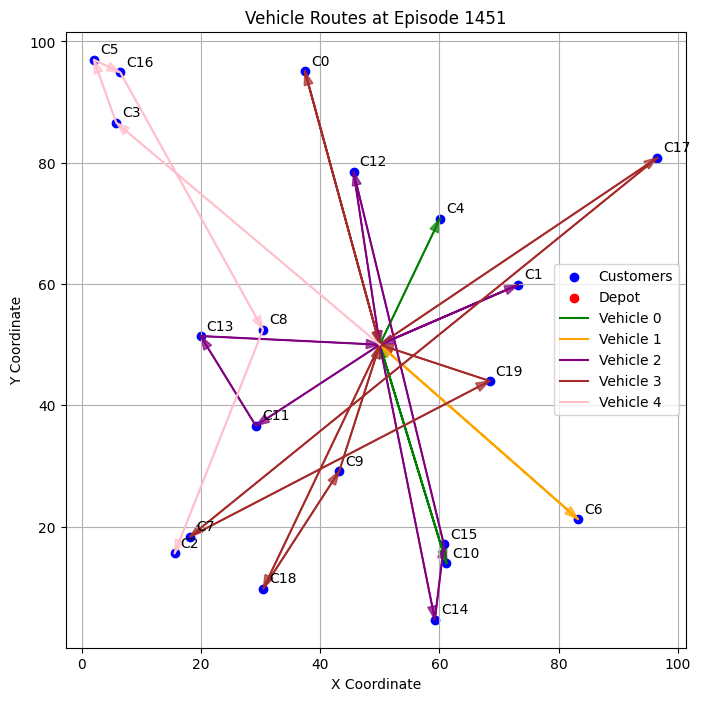

Episode 1452/2000, Total Rewards: -1200.6637264967062, Total Distance: 1090.6637264967062
Episode 1453/2000, Total Rewards: -1218.2284125512158, Total Distance: 1028.2284125512158
Episode 1454/2000, Total Rewards: -951.8470201591174, Total Distance: 846.8470201591172
Episode 1455/2000, Total Rewards: -1039.9843180207731, Total Distance: 819.9843180207731
Episode 1456/2000, Total Rewards: -1178.3412692531329, Total Distance: 953.3412692531329
Episode 1457/2000, Total Rewards: -1105.253450279598, Total Distance: 915.2534502795978
Episode 1458/2000, Total Rewards: -1153.1975051493782, Total Distance: 943.1975051493782
Episode 1459/2000, Total Rewards: -1097.2645902990962, Total Distance: 897.2645902990963
Episode 1460/2000, Total Rewards: -1049.4765784793112, Total Distance: 1039.4765784793112
Episode 1461/2000, Total Rewards: -1065.1900976993666, Total Distance: 915.1900976993666
Episode 1462/2000, Total Rewards: -1312.687703248155, Total Distance: 1047.687703248155
Episode 1463/2000, To

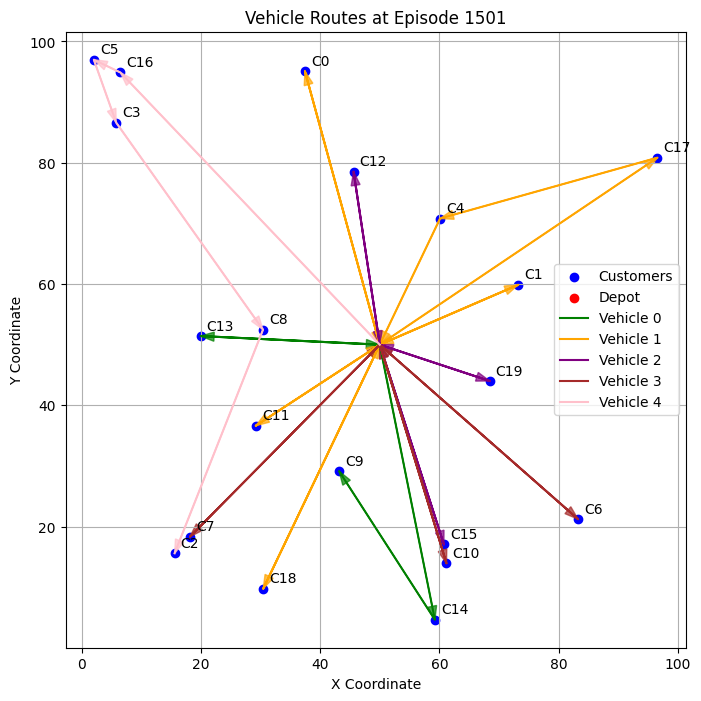

Episode 1502/2000, Total Rewards: -963.5554208756618, Total Distance: 933.5554208756618
Episode 1503/2000, Total Rewards: -1162.0908373592233, Total Distance: 937.0908373592233
Episode 1504/2000, Total Rewards: -1155.377961050932, Total Distance: 990.3779610509321
Episode 1505/2000, Total Rewards: -1277.6617530285123, Total Distance: 1062.6617530285123
Episode 1506/2000, Total Rewards: -1060.0510547682904, Total Distance: 990.0510547682904
Episode 1507/2000, Total Rewards: -1031.6893912364635, Total Distance: 936.6893912364634
Episode 1508/2000, Total Rewards: -897.6230368659398, Total Distance: 692.6230368659398
Episode 1509/2000, Total Rewards: -1117.2754747202475, Total Distance: 877.2754747202475
Episode 1510/2000, Total Rewards: -1209.857081588335, Total Distance: 949.8570815883351
Episode 1511/2000, Total Rewards: -888.4461715013935, Total Distance: 878.4461715013935
Episode 1512/2000, Total Rewards: -1277.653407002229, Total Distance: 1167.653407002229
Episode 1513/2000, Total R

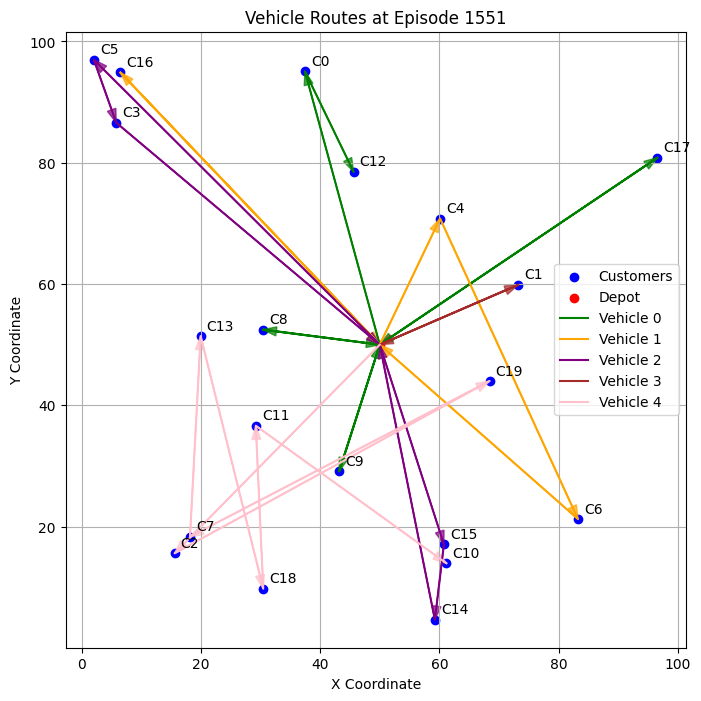

Episode 1552/2000, Total Rewards: -1046.8433231715321, Total Distance: 846.8433231715321
Episode 1553/2000, Total Rewards: -952.476826802141, Total Distance: 867.476826802141
Episode 1554/2000, Total Rewards: -1264.27861790429, Total Distance: 954.2786179042901
Episode 1555/2000, Total Rewards: -1249.351173800571, Total Distance: 954.3511738005708
Episode 1556/2000, Total Rewards: -1051.9261982400817, Total Distance: 916.9261982400817
Episode 1557/2000, Total Rewards: -987.2778820420806, Total Distance: 797.2778820420806
Episode 1558/2000, Total Rewards: -1315.0661082516895, Total Distance: 1040.0661082516895
Episode 1559/2000, Total Rewards: -1189.915925465651, Total Distance: 864.9159254656512
Episode 1560/2000, Total Rewards: -1168.6783077697755, Total Distance: 888.6783077697756
Episode 1561/2000, Total Rewards: -952.5587271001386, Total Distance: 947.5587271001386
Episode 1562/2000, Total Rewards: -1180.6193739394855, Total Distance: 1030.6193739394855
Episode 1563/2000, Total Rew

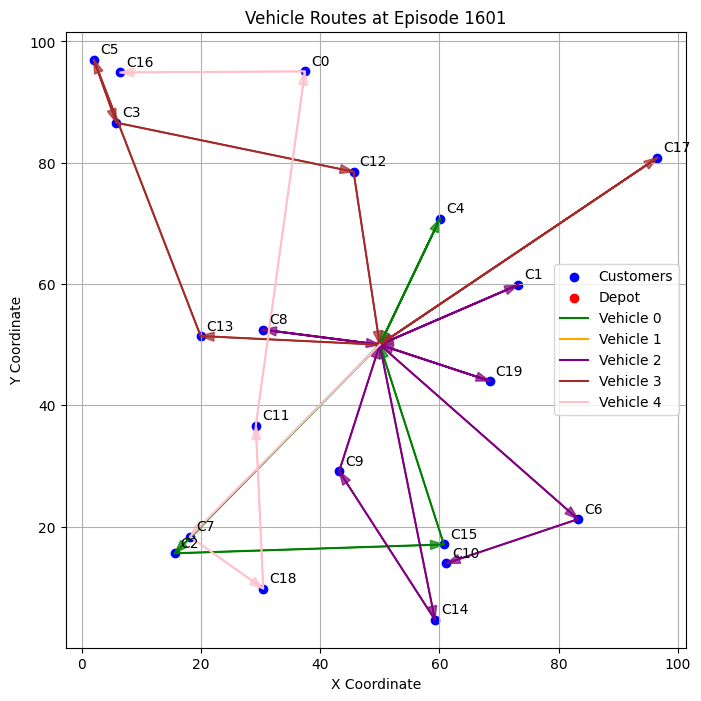

Episode 1602/2000, Total Rewards: -1620.3157294673692, Total Distance: 905.3157294673694
Episode 1603/2000, Total Rewards: -1083.58365635429, Total Distance: 1003.5836563542899
Episode 1604/2000, Total Rewards: -996.3620690226523, Total Distance: 931.3620690226523
Episode 1605/2000, Total Rewards: -1353.5292191929648, Total Distance: 968.5292191929649
Episode 1606/2000, Total Rewards: -1211.3009052691525, Total Distance: 906.3009052691525
Episode 1607/2000, Total Rewards: -1155.055275417422, Total Distance: 870.0552754174221
Episode 1608/2000, Total Rewards: -1112.5364386528959, Total Distance: 1082.5364386528959
Episode 1609/2000, Total Rewards: -1216.8512582593635, Total Distance: 986.8512582593635
Episode 1610/2000, Total Rewards: -1124.877147795054, Total Distance: 994.877147795054
Episode 1611/2000, Total Rewards: -752.6246644685441, Total Distance: 727.6246644685441
Episode 1612/2000, Total Rewards: -1102.862327039742, Total Distance: 887.8623270397421
Episode 1613/2000, Total Re

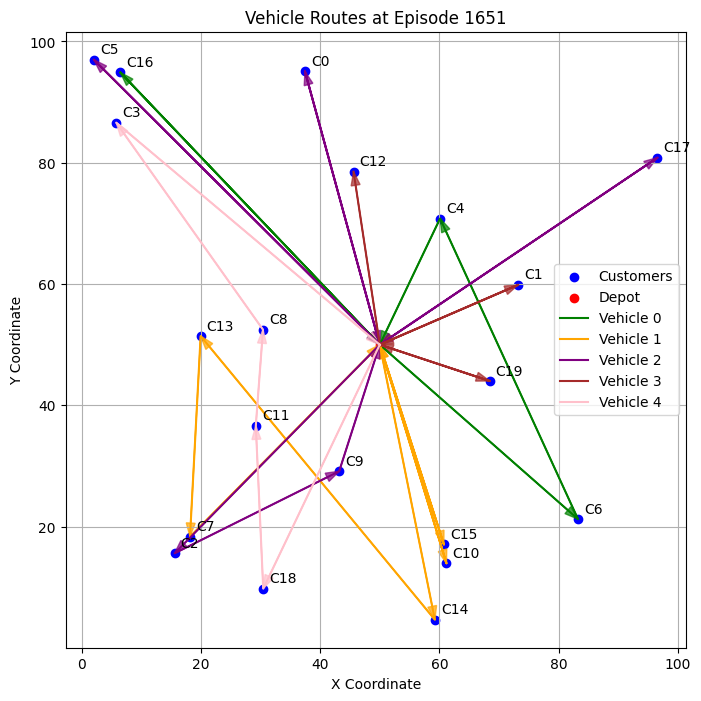

Episode 1652/2000, Total Rewards: -1212.7913681110535, Total Distance: 1047.7913681110535
Episode 1653/2000, Total Rewards: -1268.6081707379597, Total Distance: 828.6081707379598
Episode 1654/2000, Total Rewards: -941.627345483091, Total Distance: 811.627345483091
Episode 1655/2000, Total Rewards: -910.8648953276523, Total Distance: 845.8648953276523
Episode 1656/2000, Total Rewards: -964.6458828143782, Total Distance: 934.6458828143782
Episode 1657/2000, Total Rewards: -1276.643601543821, Total Distance: 951.643601543821
Episode 1658/2000, Total Rewards: -1049.7995381420938, Total Distance: 999.7995381420936
Episode 1659/2000, Total Rewards: -1140.259944576328, Total Distance: 1125.259944576328
Episode 1660/2000, Total Rewards: -927.5537847823073, Total Distance: 857.5537847823073
Episode 1661/2000, Total Rewards: -1292.4714203825392, Total Distance: 1252.4714203825392
Episode 1662/2000, Total Rewards: -1007.839636733665, Total Distance: 982.8396367336649
Episode 1663/2000, Total Rewa

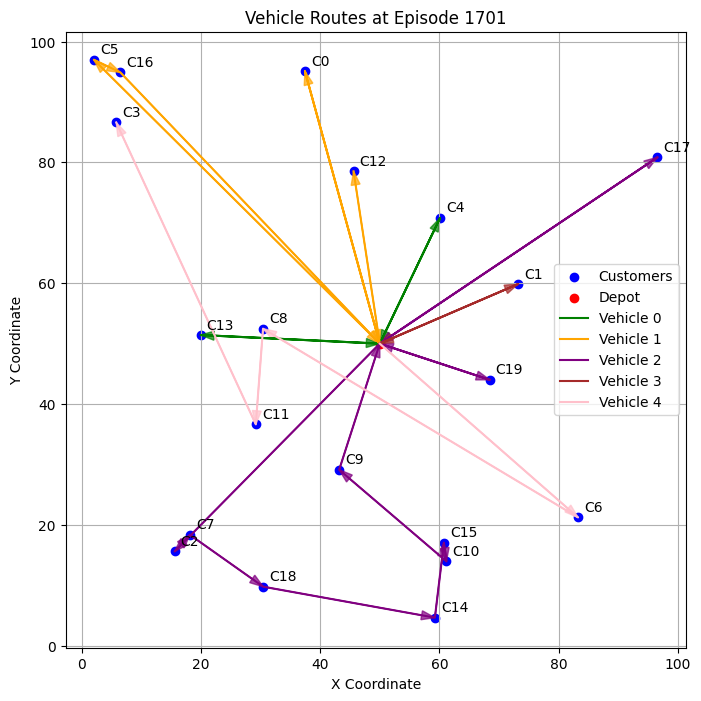

Episode 1702/2000, Total Rewards: -945.8434883699574, Total Distance: 875.8434883699574
Episode 1703/2000, Total Rewards: -1216.4167228981692, Total Distance: 966.4167228981692
Episode 1704/2000, Total Rewards: -1135.7056779929324, Total Distance: 885.7056779929324
Episode 1705/2000, Total Rewards: -1488.0998628601283, Total Distance: 998.0998628601283
Episode 1706/2000, Total Rewards: -943.3122429287258, Total Distance: 908.3122429287258
Episode 1707/2000, Total Rewards: -1233.9603578662498, Total Distance: 968.9603578662498
Episode 1708/2000, Total Rewards: -872.814814334312, Total Distance: 857.814814334312
Episode 1709/2000, Total Rewards: -1076.3426157126196, Total Distance: 931.3426157126195
Episode 1710/2000, Total Rewards: -1068.5956564626588, Total Distance: 1058.5956564626588
Episode 1711/2000, Total Rewards: -1173.78221458882, Total Distance: 1038.78221458882
Episode 1712/2000, Total Rewards: -925.0714426961496, Total Distance: 900.0714426961496
Episode 1713/2000, Total Rewa

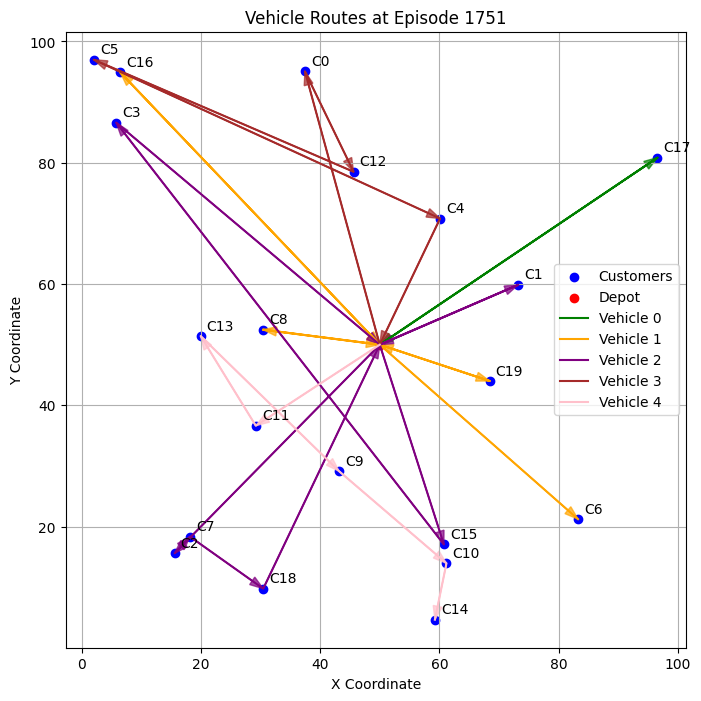

Episode 1752/2000, Total Rewards: -1296.9100431237077, Total Distance: 936.9100431237076
Episode 1753/2000, Total Rewards: -1506.265475525437, Total Distance: 1101.265475525437
Episode 1754/2000, Total Rewards: -970.7096494532353, Total Distance: 895.7096494532353
Episode 1755/2000, Total Rewards: -1568.401121910169, Total Distance: 1193.401121910169
Episode 1756/2000, Total Rewards: -1141.0692566149487, Total Distance: 926.0692566149487
Episode 1757/2000, Total Rewards: -1063.0154782892787, Total Distance: 973.0154782892787
Episode 1758/2000, Total Rewards: -1009.2455168630788, Total Distance: 859.2455168630788
Episode 1759/2000, Total Rewards: -1177.8566197195742, Total Distance: 997.8566197195742
Episode 1760/2000, Total Rewards: -1482.699754363141, Total Distance: 1052.699754363141
Episode 1761/2000, Total Rewards: -1137.2155519656635, Total Distance: 932.2155519656635
Episode 1762/2000, Total Rewards: -1315.3416048618851, Total Distance: 1150.3416048618851
Episode 1763/2000, Total

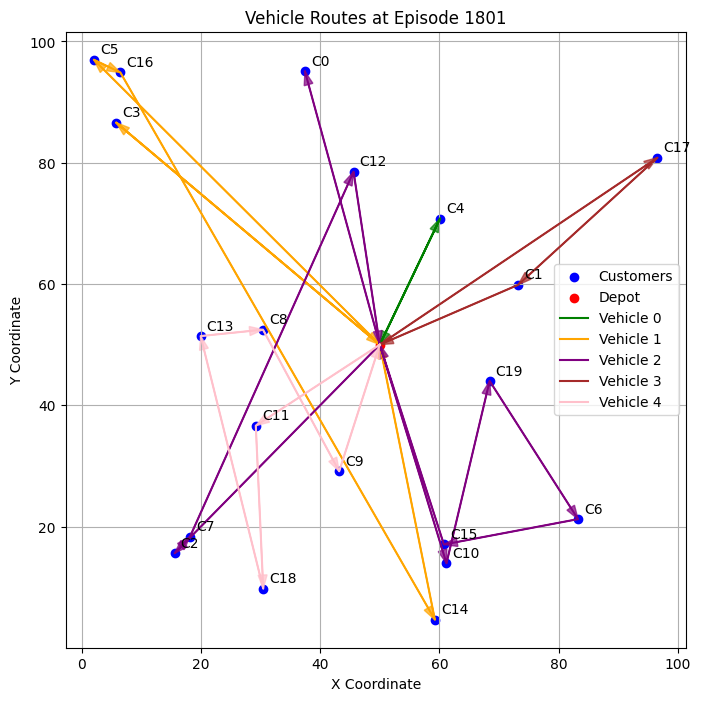

Episode 1802/2000, Total Rewards: -1242.6833619475049, Total Distance: 937.6833619475049
Episode 1803/2000, Total Rewards: -1218.269389257676, Total Distance: 1028.269389257676
Episode 1804/2000, Total Rewards: -1298.6052573521022, Total Distance: 1208.6052573521022
Episode 1805/2000, Total Rewards: -786.717076055661, Total Distance: 731.717076055661
Episode 1806/2000, Total Rewards: -1195.7659544852945, Total Distance: 935.7659544852945
Episode 1807/2000, Total Rewards: -1215.8507590791776, Total Distance: 1090.8507590791776
Episode 1808/2000, Total Rewards: -964.9347040656421, Total Distance: 869.9347040656421
Episode 1809/2000, Total Rewards: -1353.5877108737545, Total Distance: 1088.5877108737545
Episode 1810/2000, Total Rewards: -973.7483299720309, Total Distance: 963.7483299720309
Episode 1811/2000, Total Rewards: -1024.4597857998665, Total Distance: 944.4597857998664
Episode 1812/2000, Total Rewards: -1110.7729100673841, Total Distance: 1060.7729100673841
Episode 1813/2000, Tota

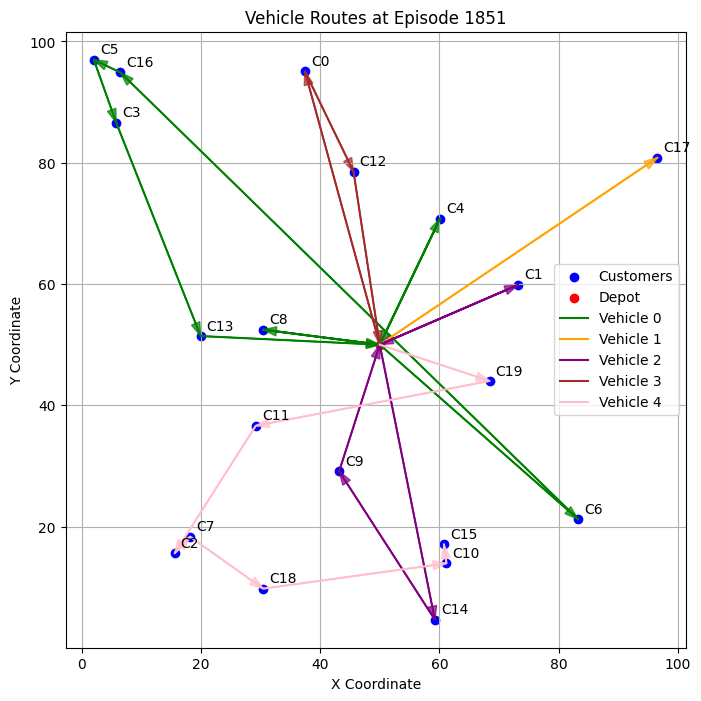

Episode 1852/2000, Total Rewards: -959.1179973229646, Total Distance: 829.1179973229646
Episode 1853/2000, Total Rewards: -1014.6978867864384, Total Distance: 929.6978867864384
Episode 1854/2000, Total Rewards: -1250.4368365950806, Total Distance: 895.4368365950805
Episode 1855/2000, Total Rewards: -1335.0515619898545, Total Distance: 1085.0515619898545
Episode 1856/2000, Total Rewards: -849.6319779070632, Total Distance: 794.6319779070632
Episode 1857/2000, Total Rewards: -1083.9325940583428, Total Distance: 908.9325940583428
Episode 1858/2000, Total Rewards: -834.5591086932518, Total Distance: 804.5591086932518
Episode 1859/2000, Total Rewards: -1021.2579327825666, Total Distance: 711.2579327825666
Episode 1860/2000, Total Rewards: -866.945659896015, Total Distance: 831.945659896015
Episode 1861/2000, Total Rewards: -1623.9000411836232, Total Distance: 1108.9000411836232
Episode 1862/2000, Total Rewards: -1192.4892437639041, Total Distance: 937.4892437639041
Episode 1863/2000, Total 

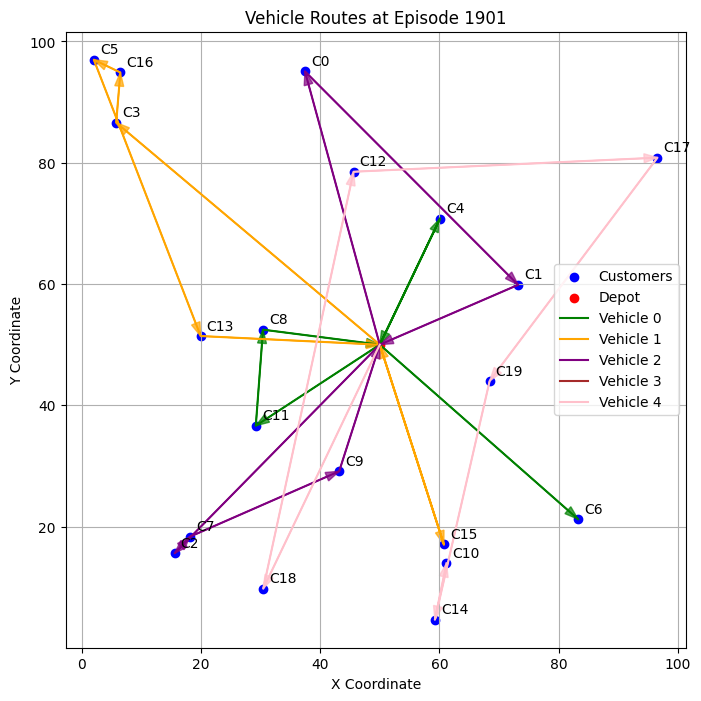

Episode 1902/2000, Total Rewards: -1366.900299016539, Total Distance: 921.9002990165391
Episode 1903/2000, Total Rewards: -1096.643276746382, Total Distance: 886.6432767463821
Episode 1904/2000, Total Rewards: -1140.363577563739, Total Distance: 1140.363577563739
Episode 1905/2000, Total Rewards: -1123.286267297939, Total Distance: 943.2862672979392
Episode 1906/2000, Total Rewards: -1411.8662890703176, Total Distance: 1031.8662890703176
Episode 1907/2000, Total Rewards: -864.437846240271, Total Distance: 854.437846240271
Episode 1908/2000, Total Rewards: -1452.6449997112495, Total Distance: 1237.6449997112497
Episode 1909/2000, Total Rewards: -1171.6311618891223, Total Distance: 1026.6311618891223
Episode 1910/2000, Total Rewards: -834.4216723651765, Total Distance: 829.4216723651765
Episode 1911/2000, Total Rewards: -1028.7016672882605, Total Distance: 1013.7016672882604
Episode 1912/2000, Total Rewards: -1358.9011986291807, Total Distance: 1028.901198629181
Episode 1913/2000, Total 

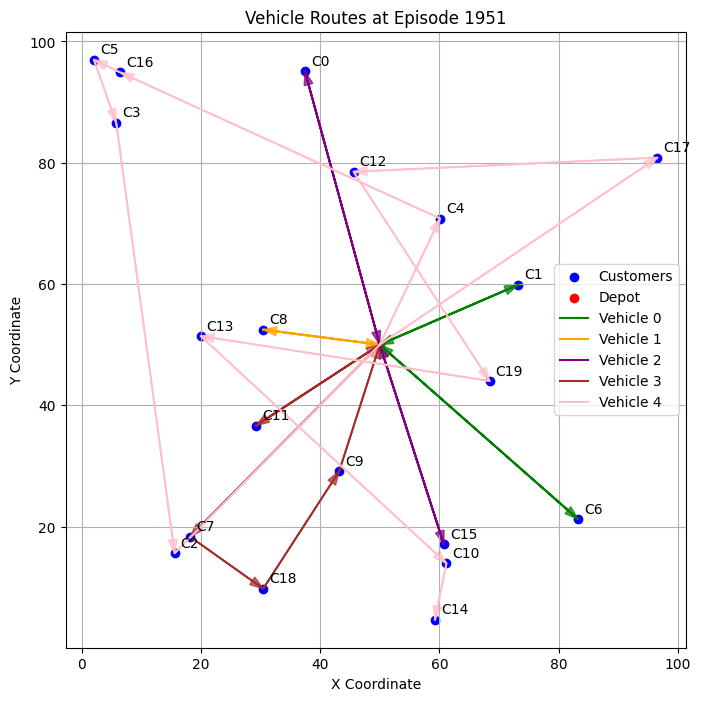

Episode 1952/2000, Total Rewards: -999.4889711253081, Total Distance: 879.4889711253081
Episode 1953/2000, Total Rewards: -1379.288464805978, Total Distance: 1279.2884648059783
Episode 1954/2000, Total Rewards: -1102.396922303028, Total Distance: 942.3969223030282
Episode 1955/2000, Total Rewards: -1037.7295990267528, Total Distance: 867.7295990267528
Episode 1956/2000, Total Rewards: -882.0922298198027, Total Distance: 732.0922298198026
Episode 1957/2000, Total Rewards: -993.9761321144874, Total Distance: 868.9761321144874
Episode 1958/2000, Total Rewards: -933.8849453545668, Total Distance: 853.8849453545668
Episode 1959/2000, Total Rewards: -1181.8730618965549, Total Distance: 946.8730618965548
Episode 1960/2000, Total Rewards: -1102.6819679503078, Total Distance: 1097.6819679503078
Episode 1961/2000, Total Rewards: -976.8648756663794, Total Distance: 901.8648756663794
Episode 1962/2000, Total Rewards: -1222.6691466328314, Total Distance: 1067.6691466328314
Episode 1963/2000, Total 

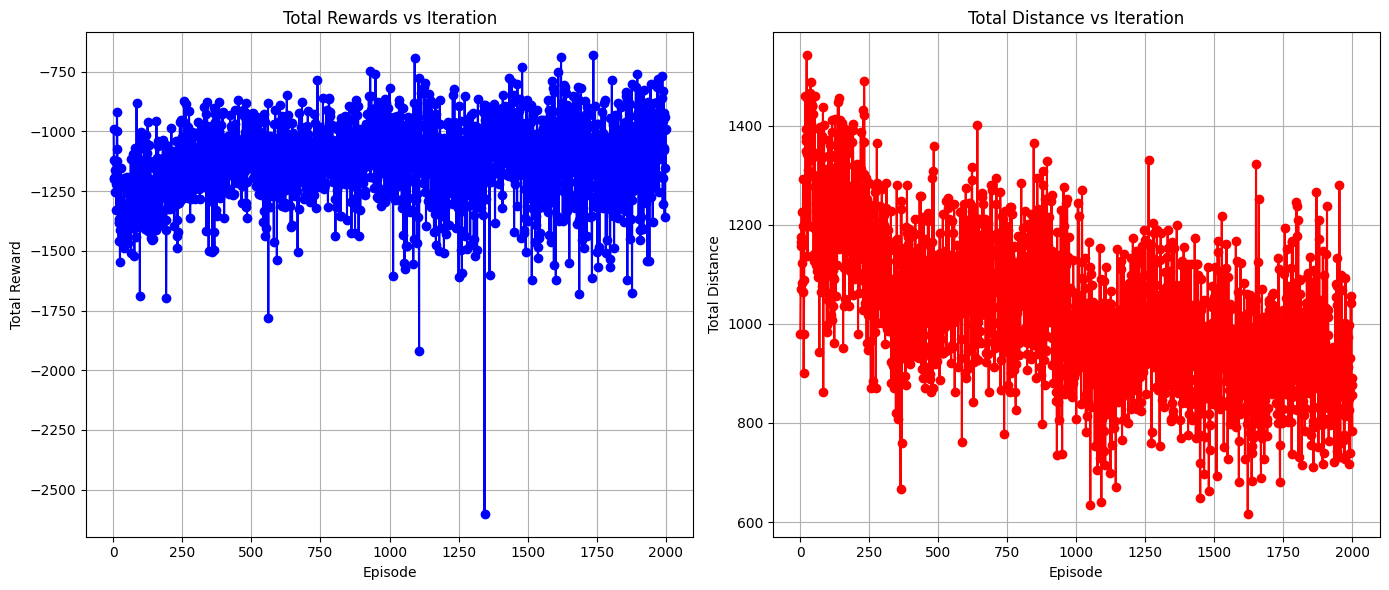

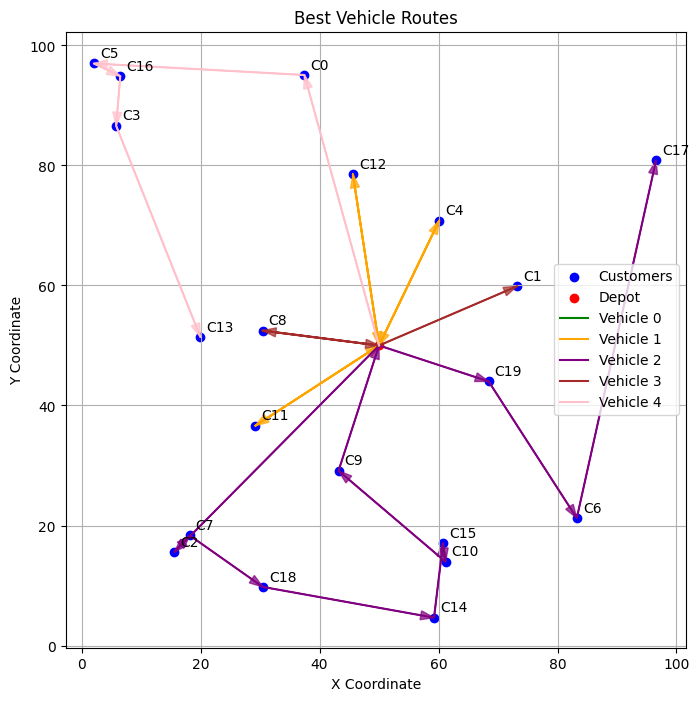


Best Total Distance: 616.8295656964107

Vehicle 0 Route:
Depot -> Depot
Distance Traveled by Vehicle 0: 0.0

Vehicle 1 Route:
Depot -> C4 -> C11 -> C12 -> Depot
Distance Traveled by Vehicle 1: 153.39791200848686

Vehicle 2 Route:
Depot -> C2 -> C7 -> C18 -> C14 -> C15 -> C10 -> C9 -> C19 -> C6 -> C17 -> Depot
Distance Traveled by Vehicle 2: 265.3711482858986

Vehicle 3 Route:
Depot -> C8 -> C1 -> Depot
Distance Traveled by Vehicle 3: 64.67344545564299

Vehicle 4 Route:
Depot -> C0 -> C5 -> C16 -> C3 -> C13 -> Depot
Distance Traveled by Vehicle 4: 133.38705994638224


In [57]:
# Initialize Environment and Agents
state_size = num_vehicles * 3 + num_customers * 4
action_size = num_customers + 1  # Customers + 'return to depot'

env = VRPEnvironment(customer_locations, customer_demands, num_vehicles, vehicle_capacity, depot_location)
agents = [DQNAgent(state_size, action_size) for _ in range(num_vehicles)]
target_agents = [DQNAgent(state_size, action_size) for _ in range(num_vehicles)]
optimizers = [optim.Adam(agent.parameters(), lr=1e-3) for agent in agents]

# Experience Replay
memory = deque(maxlen=10000)

# Training Parameters
num_episodes = 2000
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.95
target_update = 5

# Initialize lists to store total rewards and distances per episode
episode_rewards = []
episode_distances = []
best_total_distance = float('inf')
best_vehicle_routes = None  # To store the best routes
best_vehicle_route_indices = None  # To store the best route indices
best_vehicle_distances = None  # To store the best distances

# Training Loop
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_rewards = np.zeros(num_vehicles)
    while not done:
        state_vector = get_state_vector(state)
        state_tensor = torch.FloatTensor(state_vector)
        actions = []
        for i, agent in enumerate(agents):
            if random.random() < epsilon:
                # Random action
                available_actions = list(state['remaining_customers']) + [-1]
                action = random.choice(available_actions)
            else:
                # Select best action
                q_values = agent(state_tensor)
                q_values = q_values.detach().numpy()
                action_mask = np.zeros(action_size)
                action_mask[list(state['remaining_customers'])] = 1
                action_mask[num_customers] = 1  # 'Return to depot'
                q_values[action_mask == 0] = -np.inf
                action = np.argmax(q_values)
                action = action if action != num_customers else -1
            actions.append(action)
        next_state, rewards, done, _ = env.step(actions)
        total_rewards += rewards

        next_state_vector = get_state_vector(next_state)
        next_state_tensor = torch.FloatTensor(next_state_vector)

        # Store experience
        memory.append((state_tensor, actions, rewards, next_state_tensor, done))

        state = next_state

        # Learning
        if len(memory) >= batch_size:
            minibatch = random.sample(memory, batch_size)
            for i in range(num_vehicles):
                agent = agents[i]
                target_agent = target_agents[i]
                optimizer = optimizers[i]

                # Prepare batches
                state_batch = torch.stack([mb[0] for mb in minibatch])
                action_batch = torch.LongTensor([mb[1][i] if mb[1][i] != -1 else num_customers for mb in minibatch])
                reward_batch = torch.FloatTensor([mb[2][i] for mb in minibatch])
                next_state_batch = torch.stack([mb[3] for mb in minibatch])
                done_batch = torch.FloatTensor([float(mb[4]) for mb in minibatch])

                # Compute Q values
                q_values = agent(state_batch)
                state_action_values = q_values.gather(1, action_batch.unsqueeze(1)).squeeze()

                # Compute next Q values
                with torch.no_grad():
                    next_q_values = target_agent(next_state_batch)
                    max_next_q_values, _ = next_q_values.max(1)
                    expected_state_action_values = reward_batch + (1 - done_batch) * gamma * max_next_q_values

                # Compute loss
                loss = nn.functional.mse_loss(state_action_values, expected_state_action_values)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # Update target networks
    if episode % target_update == 0:
        for i in range(num_vehicles):
            target_agents[i].load_state_dict(agents[i].state_dict())

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Record total rewards and distances
    total_rewards_sum = np.sum(total_rewards)
    episode_rewards.append(total_rewards_sum)
    total_distance = np.sum(env.vehicle_distances)
    episode_distances.append(total_distance)

    # Check if this is the best solution
    if total_distance < best_total_distance:
      best_total_distance = total_distance
      best_vehicle_routes = [route.copy() for route in env.vehicle_routes]  # Deep copy the routes
      best_vehicle_route_indices = [indices.copy() for indices in env.vehicle_route_indices]  # Copy indices
      best_vehicle_distances = env.vehicle_distances.copy()  # Copy distances

    # Print total rewards and distances
    print(f"Episode {episode+1}/{num_episodes}, Total Rewards: {total_rewards_sum}, Total Distance: {total_distance}")

    # Draw solution paths
    if episode % 50 == 0:
      draw_routes(env.vehicle_routes, title=f'Vehicle Routes at Episode {episode+1}')

# Plot Total Rewards and Distances vs. Iterations
episodes = range(1, num_episodes + 1)

plt.figure(figsize=(14, 6))

# Subplot for Total Rewards
plt.subplot(1, 2, 1)
plt.plot(episodes, episode_rewards, marker='o', color='b')
plt.title('Total Rewards vs Iteration')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

# Subplot for Total Distances
plt.subplot(1, 2, 2)
plt.plot(episodes, episode_distances, marker='o', color='r')
plt.title('Total Distance vs Iteration')
plt.xlabel('Episode')
plt.ylabel('Total Distance')
plt.grid(True)

plt.tight_layout()
plt.show()

# Draw the Best Solution
if best_vehicle_routes is not None:
    draw_routes(best_vehicle_routes, title='Best Vehicle Routes')

    # Print Best Result Details
    print("\nBest Total Distance:", best_total_distance)
    for i, route_indices in enumerate(best_vehicle_route_indices):
        print(f"\nVehicle {i} Route:")
        print("Depot -> ", end='')
        for idx in route_indices:
            print(f"C{idx} -> ", end='')
        print("Depot")
        print(f"Distance Traveled by Vehicle {i}: {best_vehicle_distances[i]}")
else:
    print("No solution found.")
